# CRUST1 Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the CRUST1 Moho inversion for South America from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. This is a semi-synthetic model, where true Moho topography data from CRUST1 is used to forward model the observed gravity. This synthetic gravity data is then used to invert for Moho topography. We start by following their approach, but using Invert4Geom. We follow this by using our own approach of incorporating a starting model and adhering to points of known Moho elevation.

In [1]:
import os
import pathlib
import pickle

import numpy as np
import pandas as pd
import polartoolkit as ptk
import pooch
import pyproj
import verde as vd
import xarray as xr

import invert4geom

# set EPSG for plotting functions
os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get datasets

Here we use `Pooch` to download the CRUST1 global Moho topography dataset, and the locations of seismic measurements of Moho depth for South America. We perform some preprocessing on these datasets, subsetting them to match the geographic extent used in the paper. We convert the data to projected coordinates, instead of the geographic coordinates used in the paper.

In [2]:
url = "https://igppweb.ucsd.edu/~gabi/crust1/depthtomoho.xyz.zip"
known_hash = "36089a537ed45795557999003d0eada9935f1cc589a6ddb486a7eac716dc7ff2"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Unzip(),
)[0]

df = pd.read_csv(path, header=None, sep=r"\s+", names=["lon", "lat", "upward"])

# turn elevation to meters
df["upward"] = df.upward * 1000

# turn into grid
true_moho = df.set_index(["lat", "lon"]).to_xarray().rio.write_crs("EPSG:4326").upward

# subset to south america with buffer
region_ll = (-92, -28, -62, 22)
true_moho = true_moho.sel(
    lon=slice(region_ll[0], region_ll[1]),
    lat=slice(region_ll[2], region_ll[3]),
).drop_vars("spatial_ref")

shape = (80, 60)  # n, e

# set the projection to use
projection = pyproj.Proj("EPSG:3857")

region_ll = (-90, -30, -60, 20)
region = vd.project_region(region_ll, projection)

true_moho = vd.project_grid(
    true_moho,
    projection,
    # spacing=10e3,
    # adjust="region",
    # spacing=spacing,
    # region=region,
)

coords = vd.grid_coordinates(
    region=region,
    shape=shape,
    # spacing=spacing,
    # adjust="region",
)
grid = vd.make_xarray_grid(coords, np.ones_like(coords[0]), data_names="z").z
grid = grid.rio.set_spatial_dims("easting", "northing").rio.write_crs("epsg:4326")
true_moho = (
    true_moho.rio.set_spatial_dims("easting", "northing")
    .rio.write_crs("epsg:4326")
    .rio.write_nodata(np.nan)
)
true_moho = (
    true_moho.rio.reproject_match(grid)
    .rename({"x": "easting", "y": "northing"})
    .drop_vars("spatial_ref")
)

# recreate to drop metadata
df = true_moho.to_dataframe().reset_index()  # .astype({"easting":int,"northing":int})
true_moho = df.set_index(["northing", "easting"]).to_xarray().upward

width = region[1] - region[0]
height = region[3] - region[2]
x_mid = round(np.mean(region[:2]), -3)
y_mid = round(np.mean(region[2:]), -3)

spacing, _, _, _, _ = ptk.get_grid_info(true_moho)
spacing = round(spacing, -3)
region = (
    x_mid - (spacing * (shape[1] / 2)),
    x_mid + (spacing * (shape[1] / 2)),
    y_mid - (spacing * (shape[0] / 2)),
    y_mid + (spacing * (shape[0] / 2)),
)
true_moho = ptk.resample_grid(true_moho, spacing=spacing, region=region).rename(
    {"x": "easting", "y": "northing"}
)
true_moho

requested spacing (135000.0) is smaller than the original (135098.339453).


<xarray.DataArray 'z' (northing: 79, easting: 50)> Size: 16kB
array([[-12126.934, -11999.239, -11995.877, ...,  -9763.191,  -9582.381,
         -9704.904],
       [-12128.385, -12003.632, -12011.316, ..., -10007.558, -10116.304,
         -9893.978],
       [-12147.113, -12015.702, -12020.557, ..., -10314.801, -10612.044,
        -10249.791],
       ...,
       [-30041.104, -25788.098, -23711.795, ..., -12016.304, -11926.278,
        -10086.393],
       [-27153.316, -24115.254, -21149.28 , ..., -12052.445, -11861.389,
        -10595.313],
       [-27290.914, -24046.465, -20168.664, ..., -12062.566, -11944.055,
        -10755.179]], shape=(79, 50), dtype=float32)
Coordinates:
  * northing  (northing) float64 632B -8.37e+06 -8.235e+06 ... 2.16e+06
  * easting   (easting) float64 400B -9.99e+06 -9.855e+06 ... -3.375e+06
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-69040.859375    -9122.92089844]
    long_name:     z

In [3]:
spacing, region, _, _, _ = ptk.get_grid_info(true_moho)
spacing, region

(135000.0, (-9990000.0, -3375000.0, -8370000.0, 2160000.0))

In [4]:
url = "https://raw.githubusercontent.com/pinga-lab/paper-moho-inversion-tesseroids/master/data/crust1-point-depths.txt"
known_hash = "788426dbb100caf86b4973acf8e2b1964a2cfe517cb17c3ea9cd30ee99c9c6fb"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
)
df = pd.read_csv(path, skiprows=4, sep=" ", names=["lat", "lon", "upward"])

df = df.drop(columns="upward")

proj_coords = projection(df.lon.values, df.lat.values)
df["easting"] = proj_coords[0]
df["northing"] = proj_coords[1]

df["inside"] = vd.inside(
    (df.easting, df.northing),
    region=region,
)
df = df[df.inside].drop(columns="inside")
df

lat      lon       easting      northing
0    -9.0387 -37.0454 -4.123875e+06 -1.010383e+06
1   -19.7393 -50.2331 -5.591923e+06 -2.242173e+06
2   -18.5471 -52.0251 -5.791408e+06 -2.101686e+06
3   -18.5081 -52.0740 -5.796851e+06 -2.097107e+06
4   -20.4760 -55.6990 -6.200384e+06 -2.329506e+06
..       ...      ...           ...           ...
932 -39.0000 -70.8000 -7.881420e+06 -4.721672e+06
933 -39.0000 -70.5000 -7.848024e+06 -4.721672e+06
934 -39.0000 -70.0000 -7.792364e+06 -4.721672e+06
935 -39.0000 -69.6000 -7.747837e+06 -4.721672e+06
936 -39.0000 -68.7000 -7.647649e+06 -4.721672e+06

[937 rows x 4 columns]

In [5]:
# sample grid values at points
constraint_points = invert4geom.sample_grids(
    df,
    true_moho,
    "upward",
)
constraint_points.describe()

lat         lon       easting      northing        upward
count  937.000000  937.000000  9.370000e+02  9.370000e+02    937.000000
mean   -15.779085  -60.878246 -6.776935e+06 -1.826470e+06 -41405.453960
std     13.436299   12.894853  1.435449e+06  1.575267e+06  15471.258299
min    -54.140000  -86.300000 -9.606872e+06 -7.196715e+06 -68880.966160
25%    -25.700000  -70.346300 -7.830914e+06 -2.961972e+06 -55395.777018
50%    -17.360000  -66.780000 -7.433916e+06 -1.962772e+06 -40531.375116
75%     -7.639000  -47.794900 -5.320504e+06 -8.529002e+05 -31580.402943
max     13.949700  -35.104000 -3.907759e+06  1.568446e+06 -10942.443504

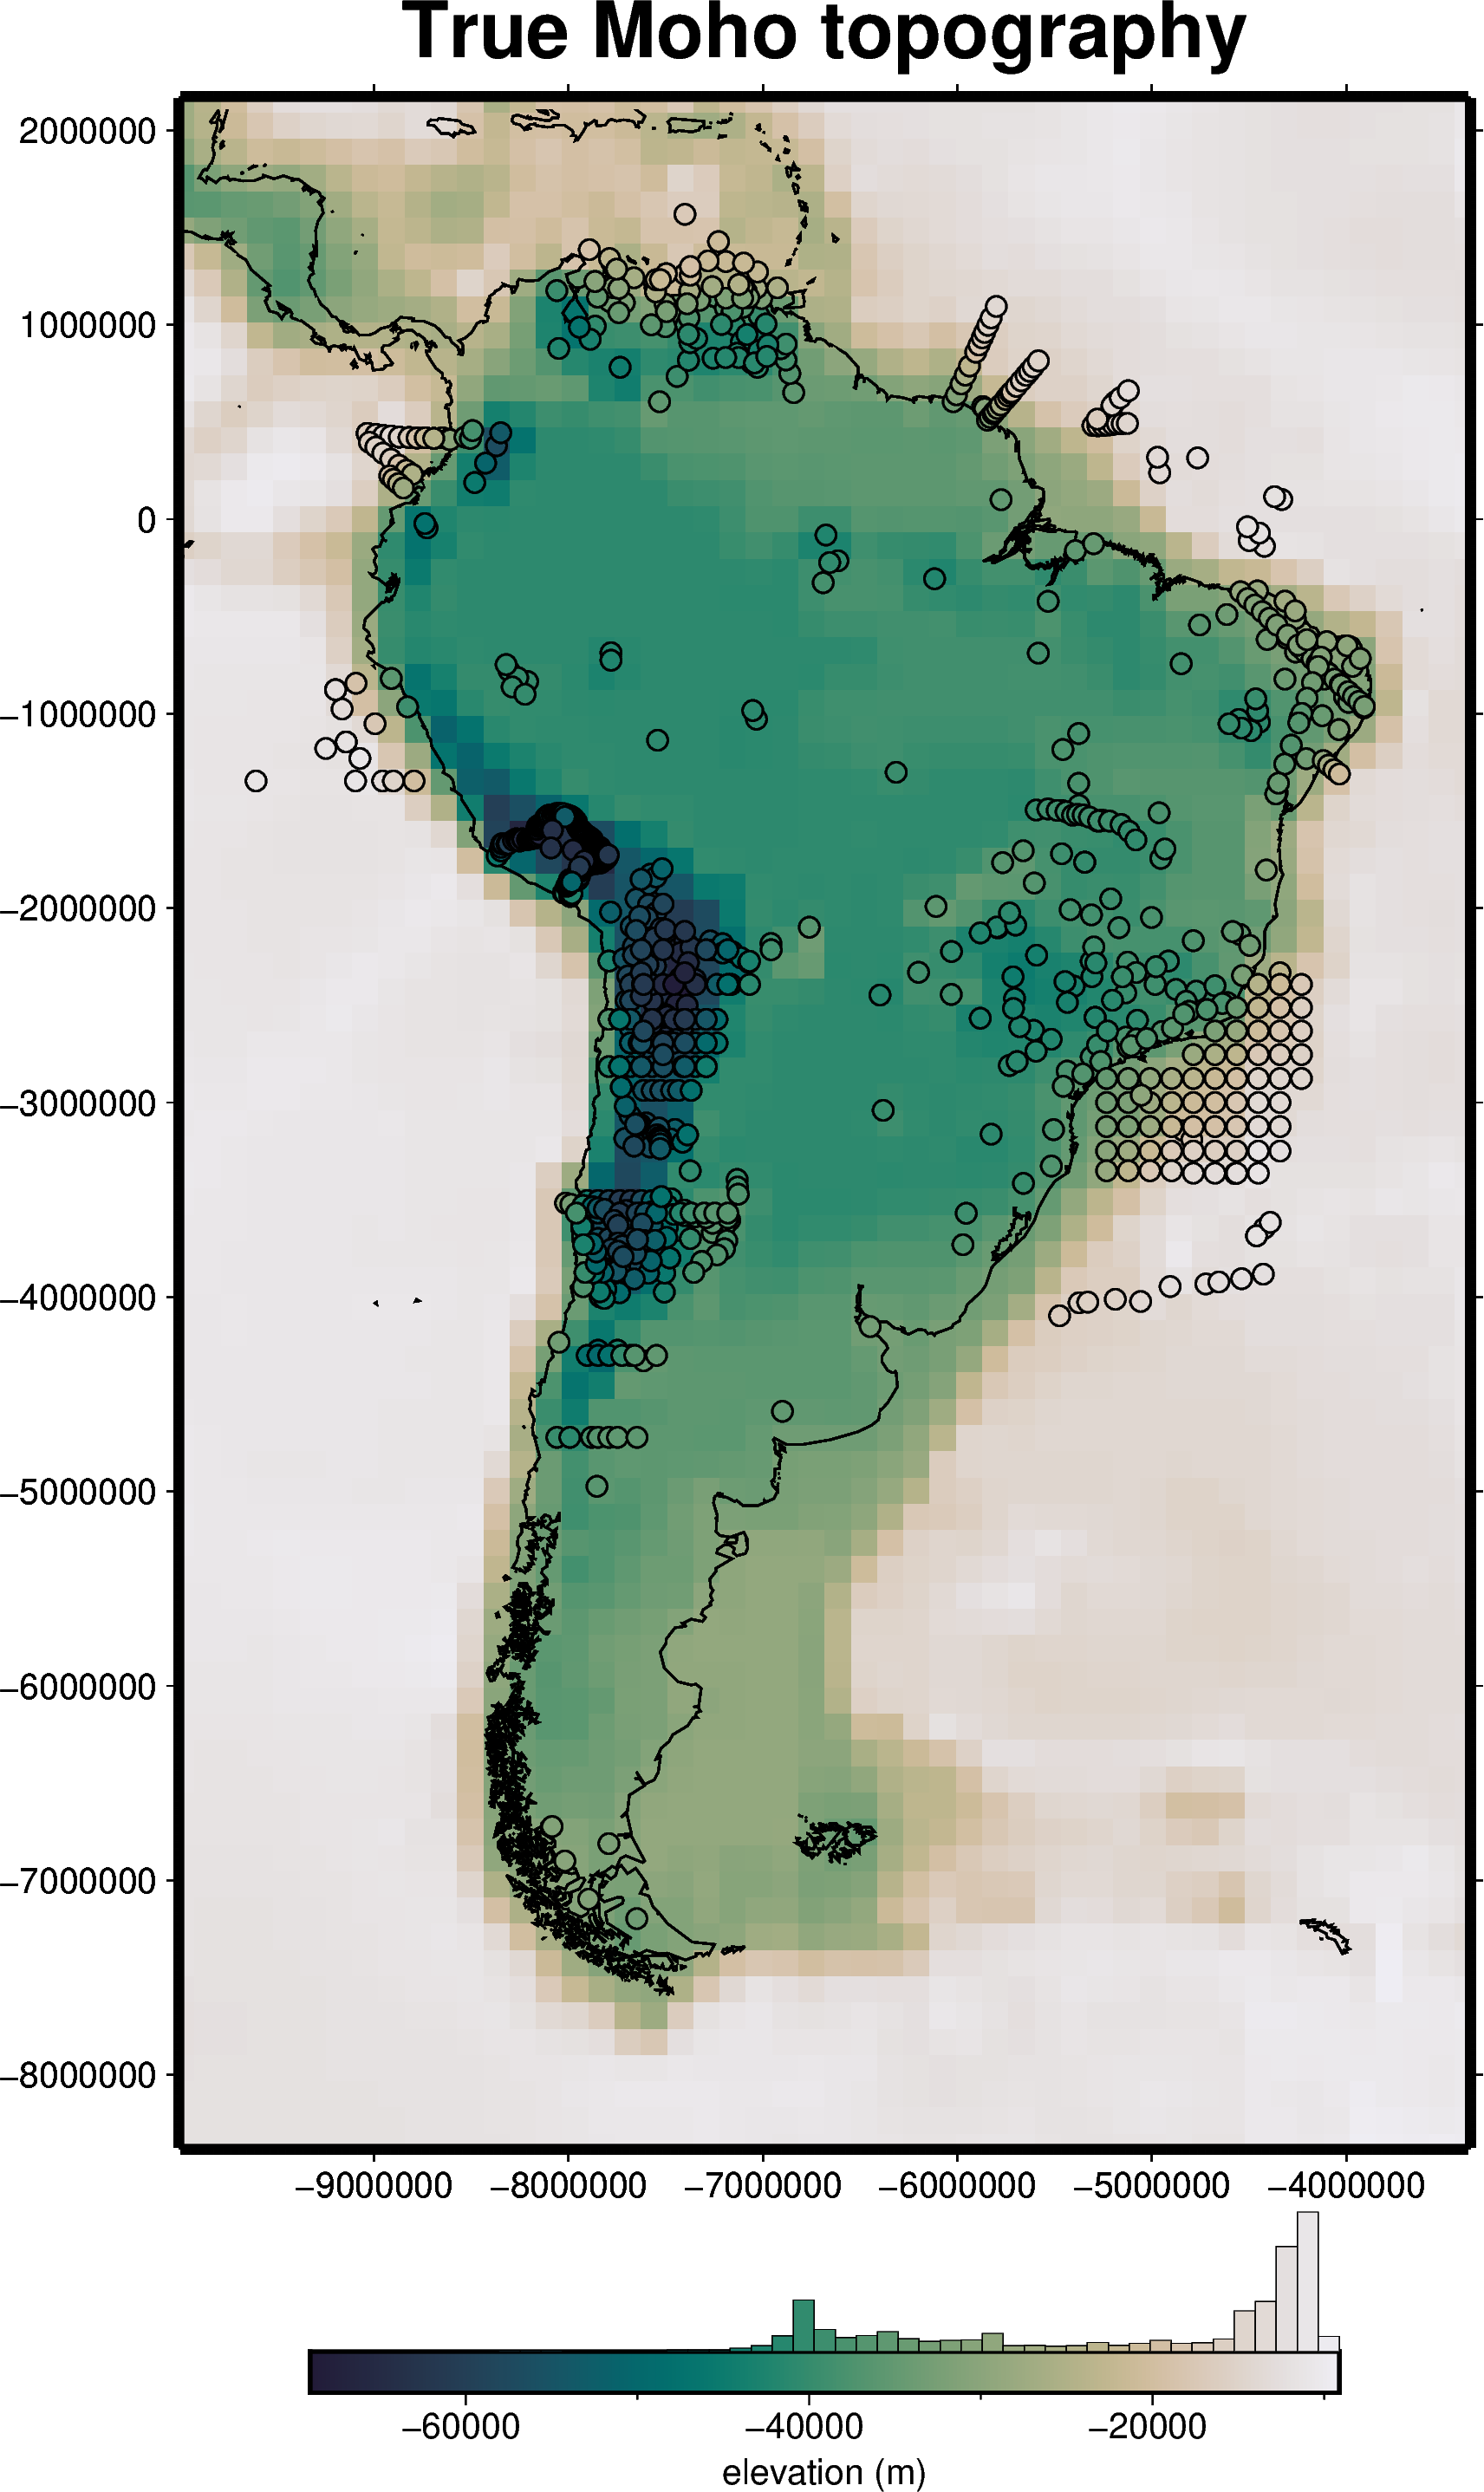

In [6]:
fig = ptk.plot_grid(
    true_moho,
    fig_height=20,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_yoffset=2,
    cbar_label="elevation (m)",
    coast=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="c.2c",
    points_fill="upward",
    points_pen=".6p,black",
)

fig.show()

## Observed gravity data
We can now forward-model the effects of this moho model and add some noise to make a synthetic observed gravity dataset.

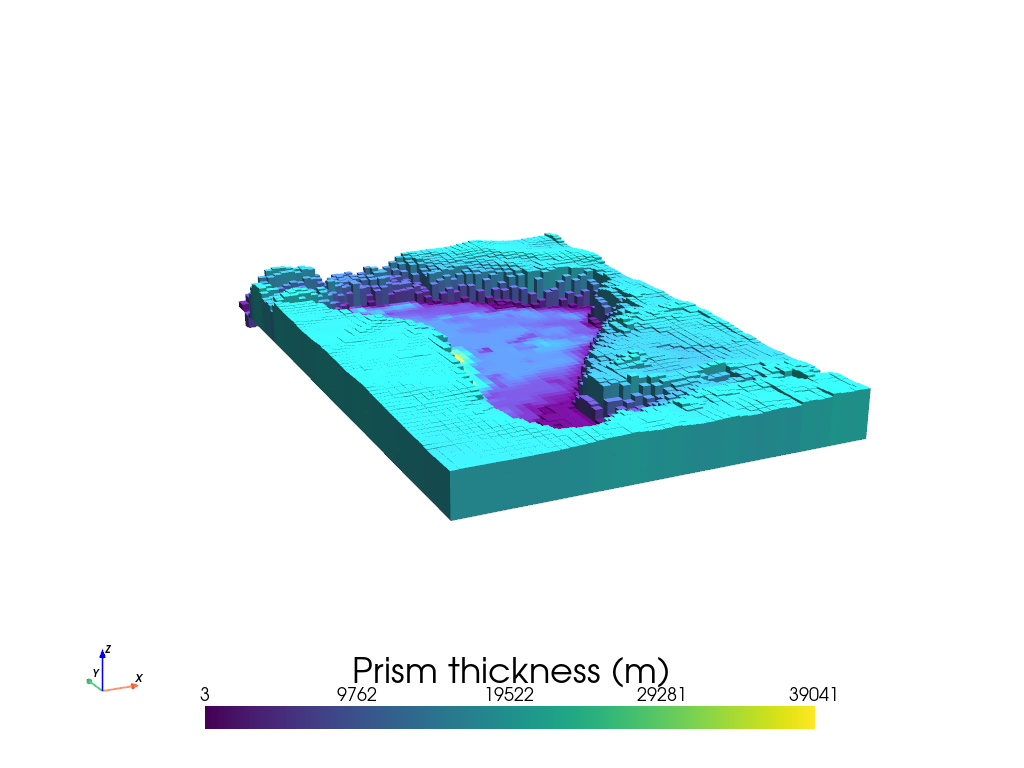

In [7]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 350

# make prism layer
true_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=true_moho.to_dataset(name="upward"),
)

true_model.inv.plot_model(
    color_by="thickness",
    # color_by="density",
    zscale=40,
)

In [8]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

grav_data.inv.forward_gravity(true_model, "gravity_anomaly")

# contaminate gravity with 5 mGal random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_data

<xarray.Dataset> Size: 64kB
Dimensions:          (northing: 79, easting: 50)
Coordinates:
  * easting          (easting) float64 400B -9.99e+06 -9.855e+06 ... -3.375e+06
  * northing         (northing) float64 632B -8.37e+06 -8.235e+06 ... 2.16e+06
Data variables:
    upward           (northing, easting) float64 32kB 5e+04 5e+04 ... 5e+04
    gravity_anomaly  (northing, easting) float64 32kB 149.5 177.5 ... 162.0
Attributes:
    region:        (-9990000.0, -3375000.0, -8370000.0, 2160000.0)
    spacing:       135000.0
    buffer_width:  675000.0
    inner_region:  (-9315000.0, -4050000.0, -7695000.0, 1485000.0)
    dataset_type:  data
    model_type:    prisms

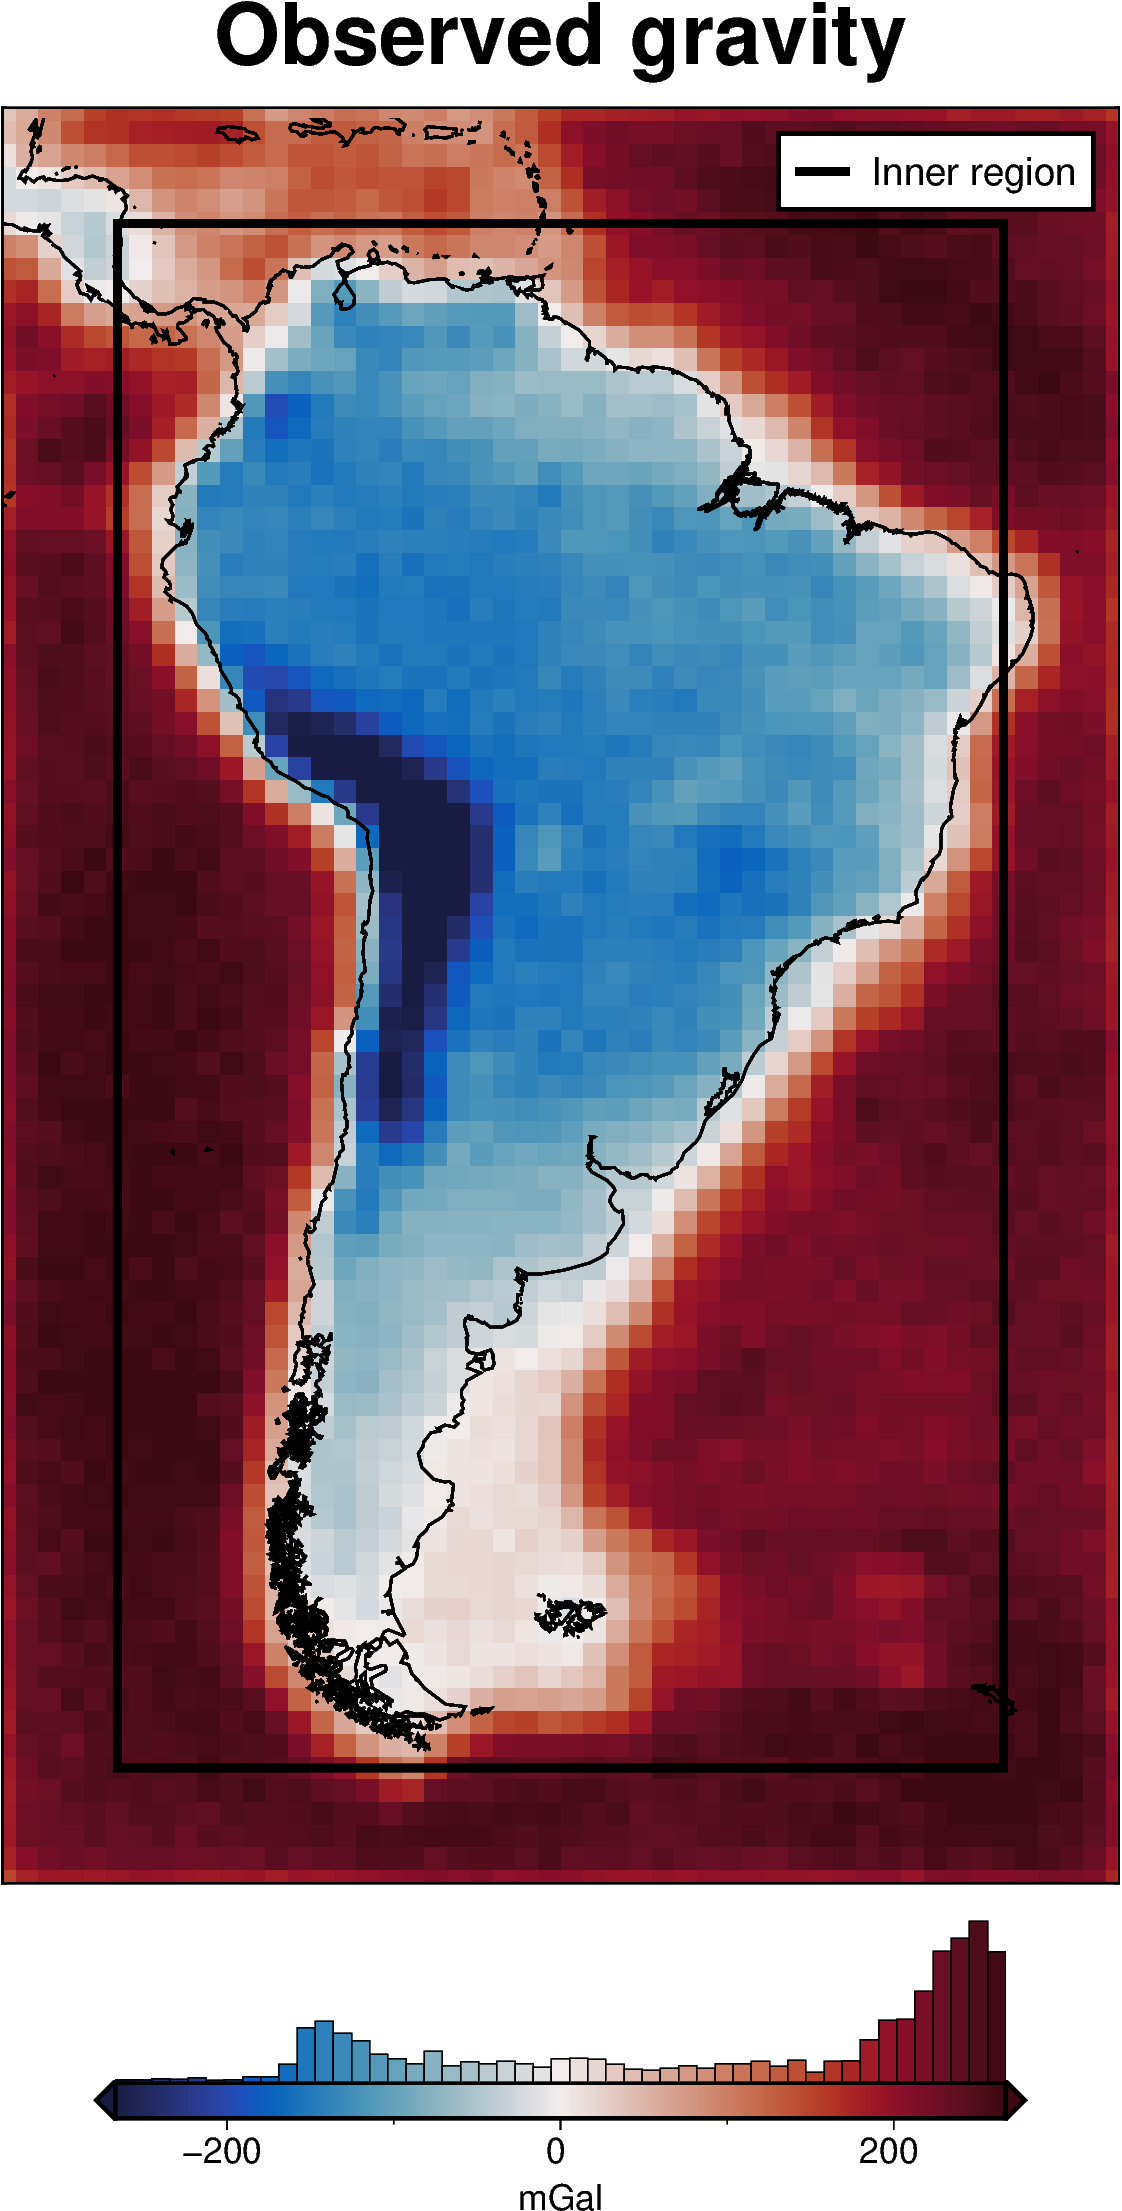

In [9]:
grav_data.inv.plot_observed(
    coast=True,
)

## Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho. This is used during the damping parameter cross-validation.

In [10]:
true_zref, true_density_contrast

(-30000.0, 350)

In [11]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
starting_topography = xr.full_like(true_moho, true_zref).to_dataset(name="upward")

model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=starting_topography,
)

# calculate the forward gravity of the initial model
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data.inv.df

  0%|                                          | 0/3950 [00:00<?, ?it/s]

northing    easting   upward  gravity_anomaly  forward_gravity  \
0    -8370000.0 -9990000.0  50000.0       149.468566             -0.0   
1    -8370000.0 -9855000.0  50000.0       177.528197             -0.0   
2    -8370000.0 -9720000.0  50000.0       188.262762             -0.0   
3    -8370000.0 -9585000.0  50000.0       188.331313             -0.0   
4    -8370000.0 -9450000.0  50000.0       186.659551             -0.0   
...         ...        ...      ...              ...              ...   
3945  2160000.0 -3915000.0  50000.0       181.167508             -0.0   
3946  2160000.0 -3780000.0  50000.0       179.901788             -0.0   
3947  2160000.0 -3645000.0  50000.0       187.324178             -0.0   
3948  2160000.0 -3510000.0  50000.0       178.033999             -0.0   
3949  2160000.0 -3375000.0  50000.0       162.044301             -0.0   

          misfit  reg         res  starting_forward_gravity  starting_misfit  \
0     149.468566  0.0  149.468566                      -0.0       149.468566   
1     177.528197  0.0  177.528197                      -0.0       177.528197   
2     188.262762  0.0  188.262762                      -0.0       188.262762   
3     188.331313  0.0  188.331313                      -0.0       188.331313   
4     186.659551  0.0  186.659551                      -0.0       186.659551   
...          ...  ...         ...                       ...              ...   
3945  181.167508  0.0  181.167508                      -0.0       181.167508   
3946  179.901788  0.0  179.901788                      -0.0       179.901788   
3947  187.324178  0.0  187.324178                      -0.0       187.324178   
3948  178.033999  0.0  178.033999                      -0.0       178.033999   
3949  162.044301  0.0  162.044301                      -0.0       162.044301   

      starting_reg  starting_res  
0              0.0    149.468566  
1              0.0    177.528197  
2              0.0    188.262762  
3              0.0    188.331313  
4              0.0    186.659551  
...            ...           ...  
3945           0.0    181.167508  
3946           0.0    179.901788  
3947           0.0    187.324178  
3948           0.0    178.033999  
3949           0.0    162.044301  

[3950 rows x 12 columns]

makecpt [ERROR]: Option T: min >= max


supplied min value is greater or equal to max value


makecpt [ERROR]: Option T: min >= max


supplied min value is greater or equal to max value


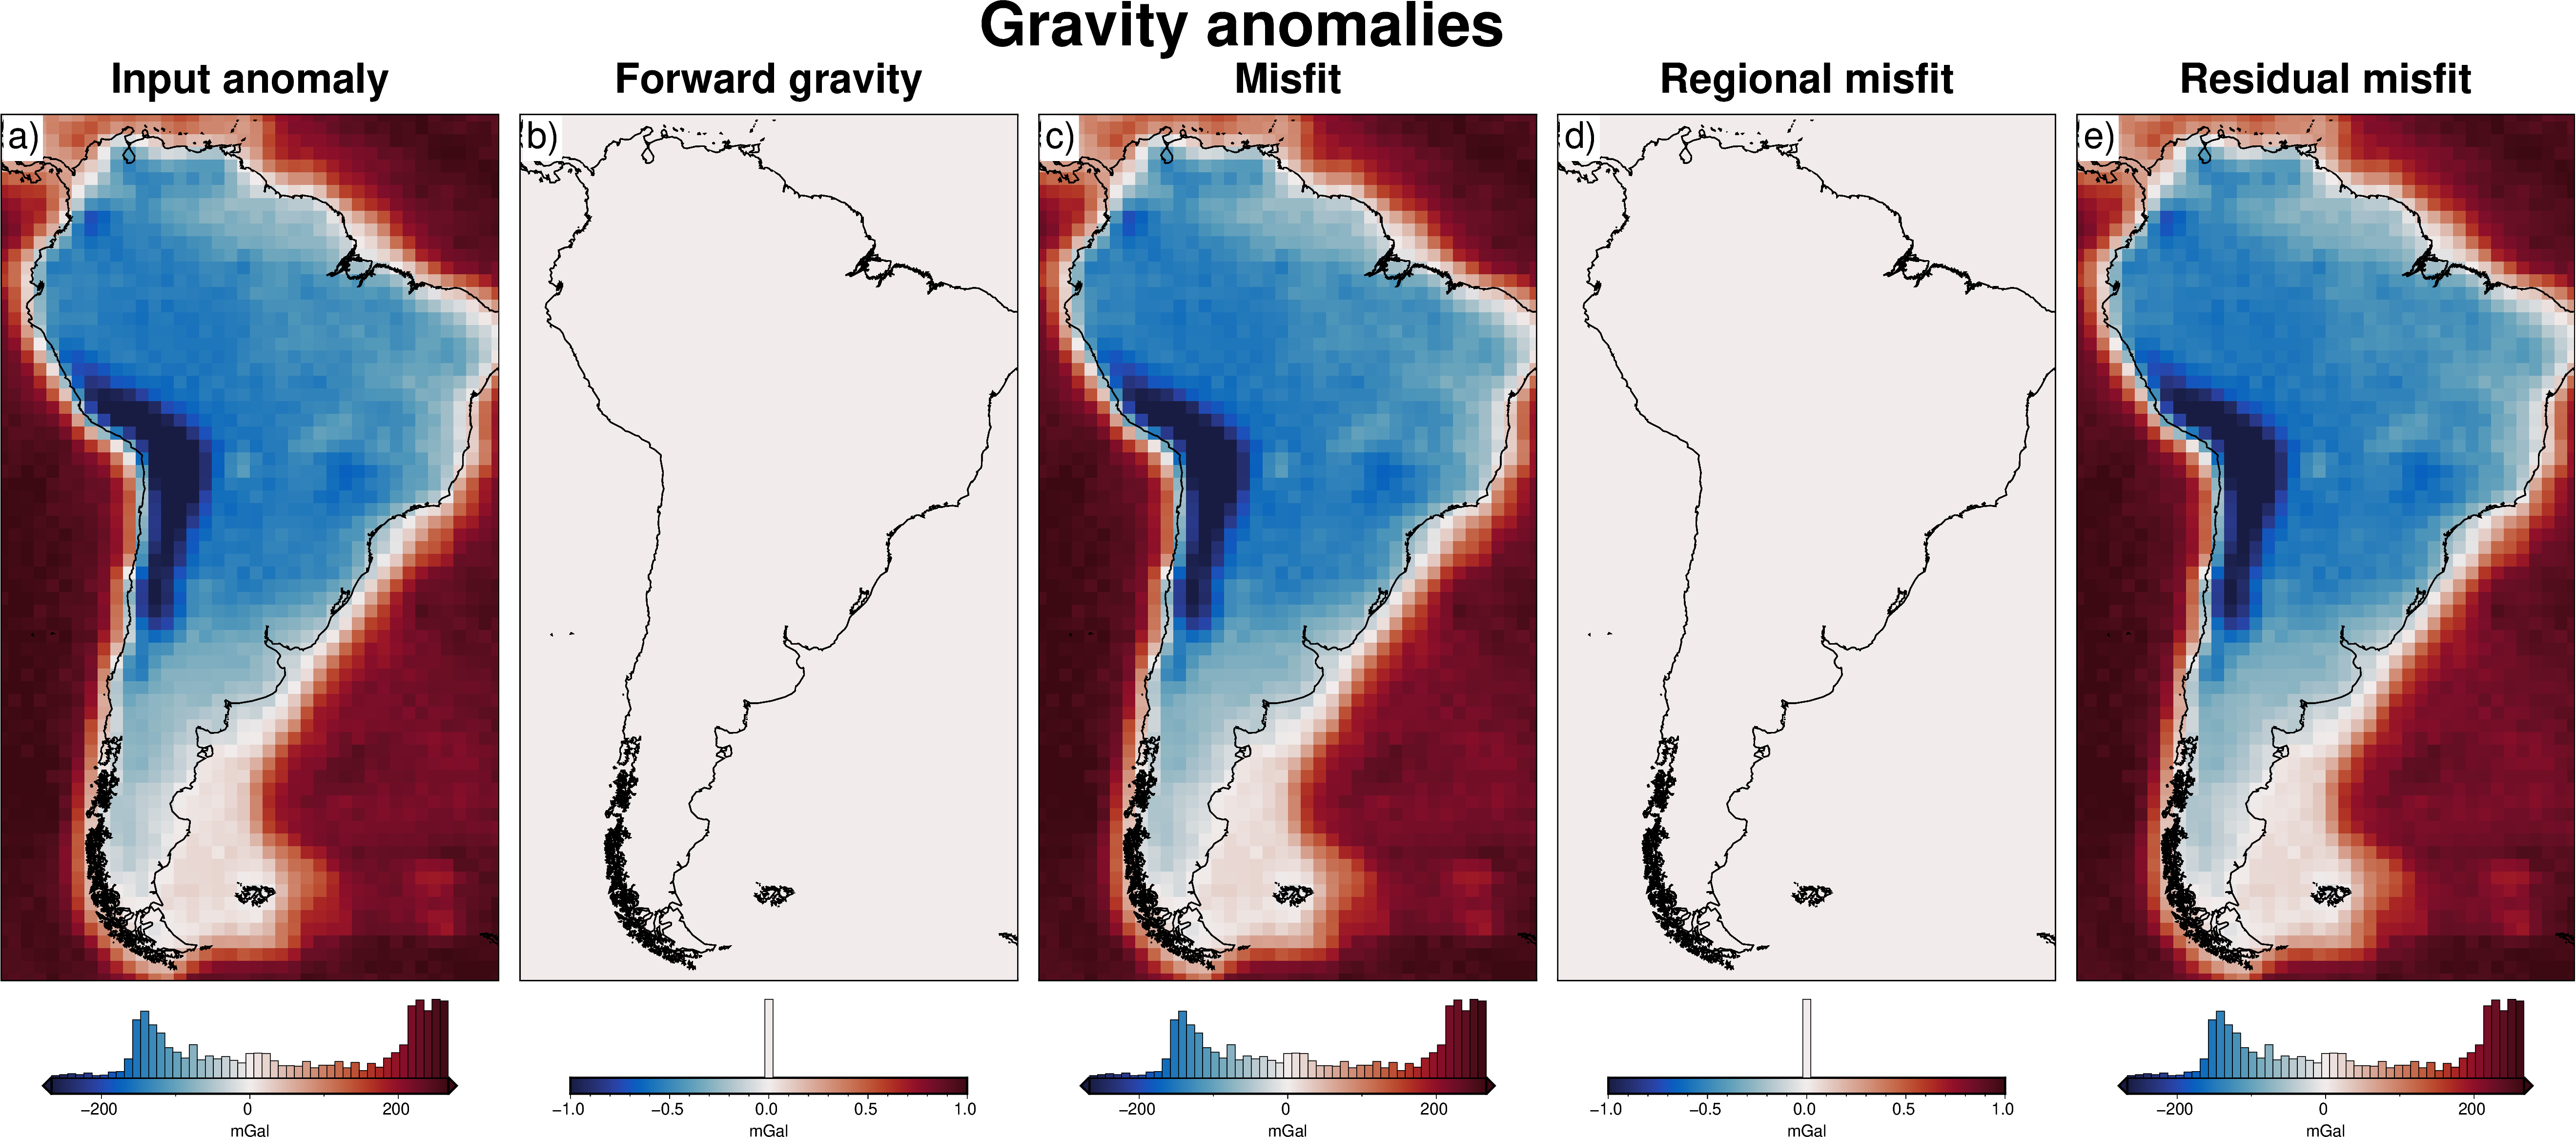

In [12]:
grav_data.inv.plot_anomalies(
    coast=True,
)

## Damping parameter cross validation

### Get individual score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

In [13]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.01,
    # set stopping criteria
    max_iterations=300,
    l2_norm_tolerance=2.2,  # gravity error is 5 mGal or L2-norm of ~2.2
    delta_l2_norm_tolerance=1.008,
)

In [14]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data.inv.df

northing    easting   test   upward  gravity_anomaly  forward_gravity  \
0     -8370000.0 -9990000.0  False  50000.0       149.468567              0.0   
1     -8370000.0 -9922500.0   True  50000.0       164.581200              0.0   
2     -8370000.0 -9855000.0  False  50000.0       177.528198              0.0   
3     -8370000.0 -9787500.0   True  50000.0       184.644919              0.0   
4     -8370000.0 -9720000.0  False  50000.0       188.262756              0.0   
...          ...        ...    ...      ...              ...              ...   
15538  2160000.0 -3645000.0  False  50000.0       187.324173              0.0   
15539  2160000.0 -3577500.0   True  50000.0       184.142340              0.0   
15540  2160000.0 -3510000.0  False  50000.0       178.033997              0.0   
15541  2160000.0 -3442500.0   True  50000.0       170.457867              0.0   
15542  2160000.0 -3375000.0  False  50000.0       162.044296              0.0   

           misfit  reg         res  starting_forward_gravity  starting_misfit  \
0      149.468567  0.0  149.468567                       0.0       149.468567   
1      164.581200  0.0  164.581200                       0.0       164.581200   
2      177.528198  0.0  177.528198                       0.0       177.528198   
3      184.644919  0.0  184.644919                       0.0       184.644919   
4      188.262756  0.0  188.262756                       0.0       188.262756   
...           ...  ...         ...                       ...              ...   
15538  187.324173  0.0  187.324173                       0.0       187.324173   
15539  184.142340  0.0  184.142340                       0.0       184.142340   
15540  178.033997  0.0  178.033997                       0.0       178.033997   
15541  170.457867  0.0  170.457867                       0.0       170.457867   
15542  162.044296  0.0  162.044296                       0.0       162.044296   

       starting_reg  starting_res  
0               0.0    149.468567  
1               0.0    164.581200  
2               0.0    177.528198  
3               0.0    184.644919  
4               0.0    188.262756  
...             ...           ...  
15538           0.0    187.324173  
15539           0.0    184.142340  
15540           0.0    178.033997  
15541           0.0    170.457867  
15542           0.0    162.044296  

[15543 rows x 13 columns]

In [15]:
inv.model

<xarray.Dataset> Size: 222kB
Dimensions:                (northing: 79, easting: 50)
Coordinates:
  * easting                (easting) float64 400B -9.99e+06 ... -3.375e+06
  * northing               (northing) float64 632B -8.37e+06 ... 2.16e+06
    top                    (northing, easting) float32 16kB -3e+04 ... -3e+04
    bottom                 (northing, easting) float64 32kB -3e+04 ... -3e+04
Data variables:
    density                (northing, easting) int64 32kB 350 350 ... 350 350
    thickness              (northing, easting) float64 32kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float32 16kB -3e+04 ... -3e+04
    topography             (northing, easting) float32 16kB -3e+04 ... -3e+04
    mask                   (northing, easting) float32 16kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 32kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 32kB nan nan ... nan nan
Attributes:
    inner_region:      (-9990000.0, -3375000.0, -8370000.0, 2160000.0)
    zref:              -30000.0
    density_contrast:  350
    region:            (-9990000.0, -3375000.0, -8370000.0, 2160000.0)
    spacing:           135000.0
    dataset_type:      model
    model_type:        prisms

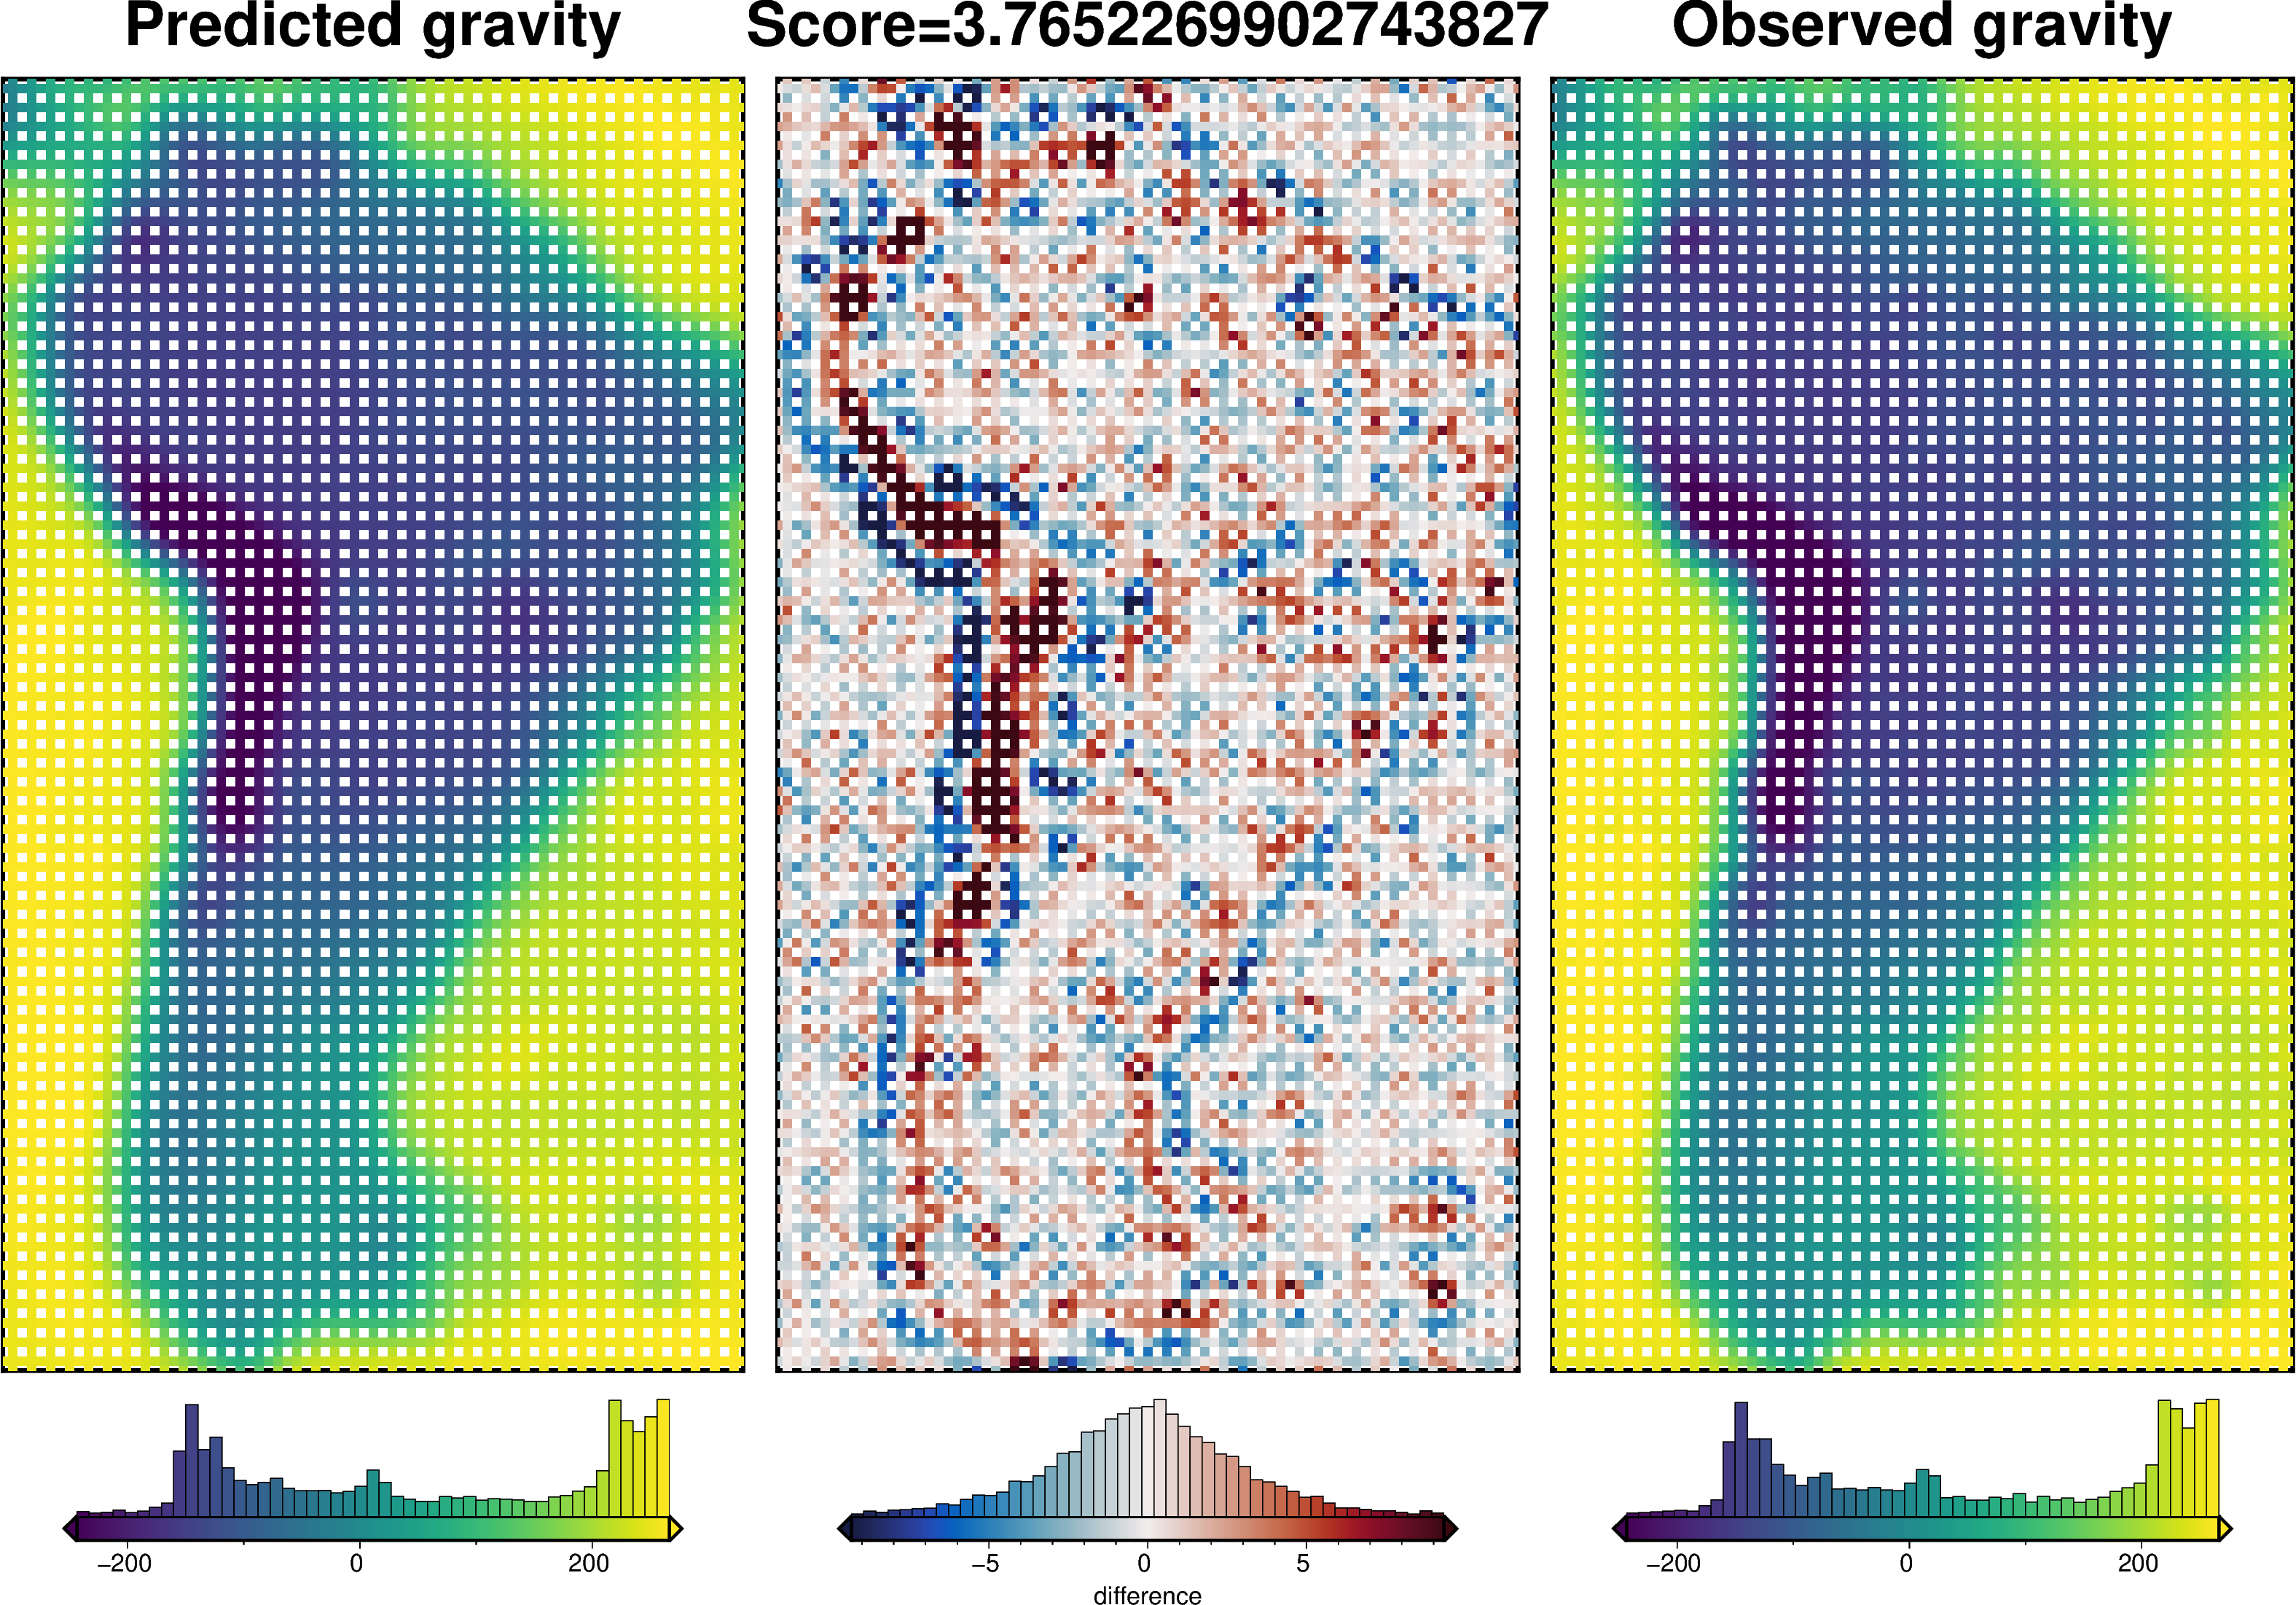

np.float64(3.7652269902743827)

In [16]:
# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
grav_optimization_object = inv.gravity_score(
    plot=True,
)
inv.gravity_best_score

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.0027239940125771685

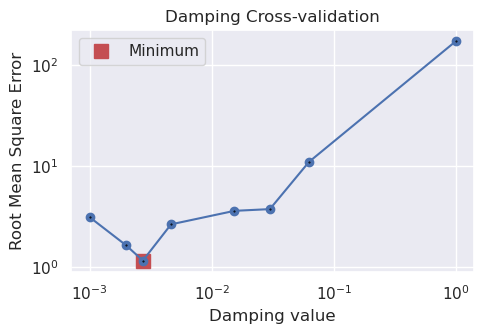

In [17]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    plot_scores=True,
    fname="../tmp/uieda_CRUST1_damping_CV",
)
inv.solver_damping

In [18]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [19]:
study.trials_dataframe().sort_values("value")

number       value             datetime_start          datetime_complete  \
7       7    1.161202 2026-02-08 11:36:04.398714 2026-02-08 11:36:10.974779   
2       2    1.646939 2026-02-08 11:32:17.130345 2026-02-08 11:32:23.907027   
6       6    2.654991 2026-02-08 11:35:59.422134 2026-02-08 11:36:04.397743   
0       0    3.119000 2026-02-08 11:32:04.840089 2026-02-08 11:32:12.444539   
4       4    3.612146 2026-02-08 11:34:39.237294 2026-02-08 11:34:57.480822   
5       5    3.757542 2026-02-08 11:34:57.481766 2026-02-08 11:35:59.421290   
3       3   11.040302 2026-02-08 11:32:23.908081 2026-02-08 11:34:39.228279   
1       1  172.800449 2026-02-08 11:32:12.445745 2026-02-08 11:32:17.129340   

                duration  params_damping  \
7 0 days 00:00:06.576065        0.002724   
2 0 days 00:00:06.776682        0.001983   
6 0 days 00:00:04.975609        0.004639   
0 0 days 00:00:07.604450        0.001000   
4 0 days 00:00:18.243528        0.015357   
5 0 days 00:01:01.939524        0.029955   
3 0 days 00:02:15.320198        0.062714   
1 0 days 00:00:04.683595        1.000000   

                         user_attrs_fname system_attrs_fixed_params     state  
7  ../tmp/uieda_CRUST1_damping_CV_trial_7                       NaN  COMPLETE  
2  ../tmp/uieda_CRUST1_damping_CV_trial_2                       NaN  COMPLETE  
6  ../tmp/uieda_CRUST1_damping_CV_trial_6                       NaN  COMPLETE  
0  ../tmp/uieda_CRUST1_damping_CV_trial_0        {'damping': 0.001}  COMPLETE  
4  ../tmp/uieda_CRUST1_damping_CV_trial_4                       NaN  COMPLETE  
5  ../tmp/uieda_CRUST1_damping_CV_trial_5                       NaN  COMPLETE  
3  ../tmp/uieda_CRUST1_damping_CV_trial_3                       NaN  COMPLETE  
1  ../tmp/uieda_CRUST1_damping_CV_trial_1            {'damping': 1}  COMPLETE

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 7a in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

### Plot results

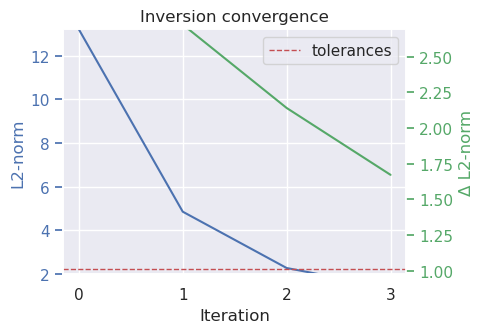

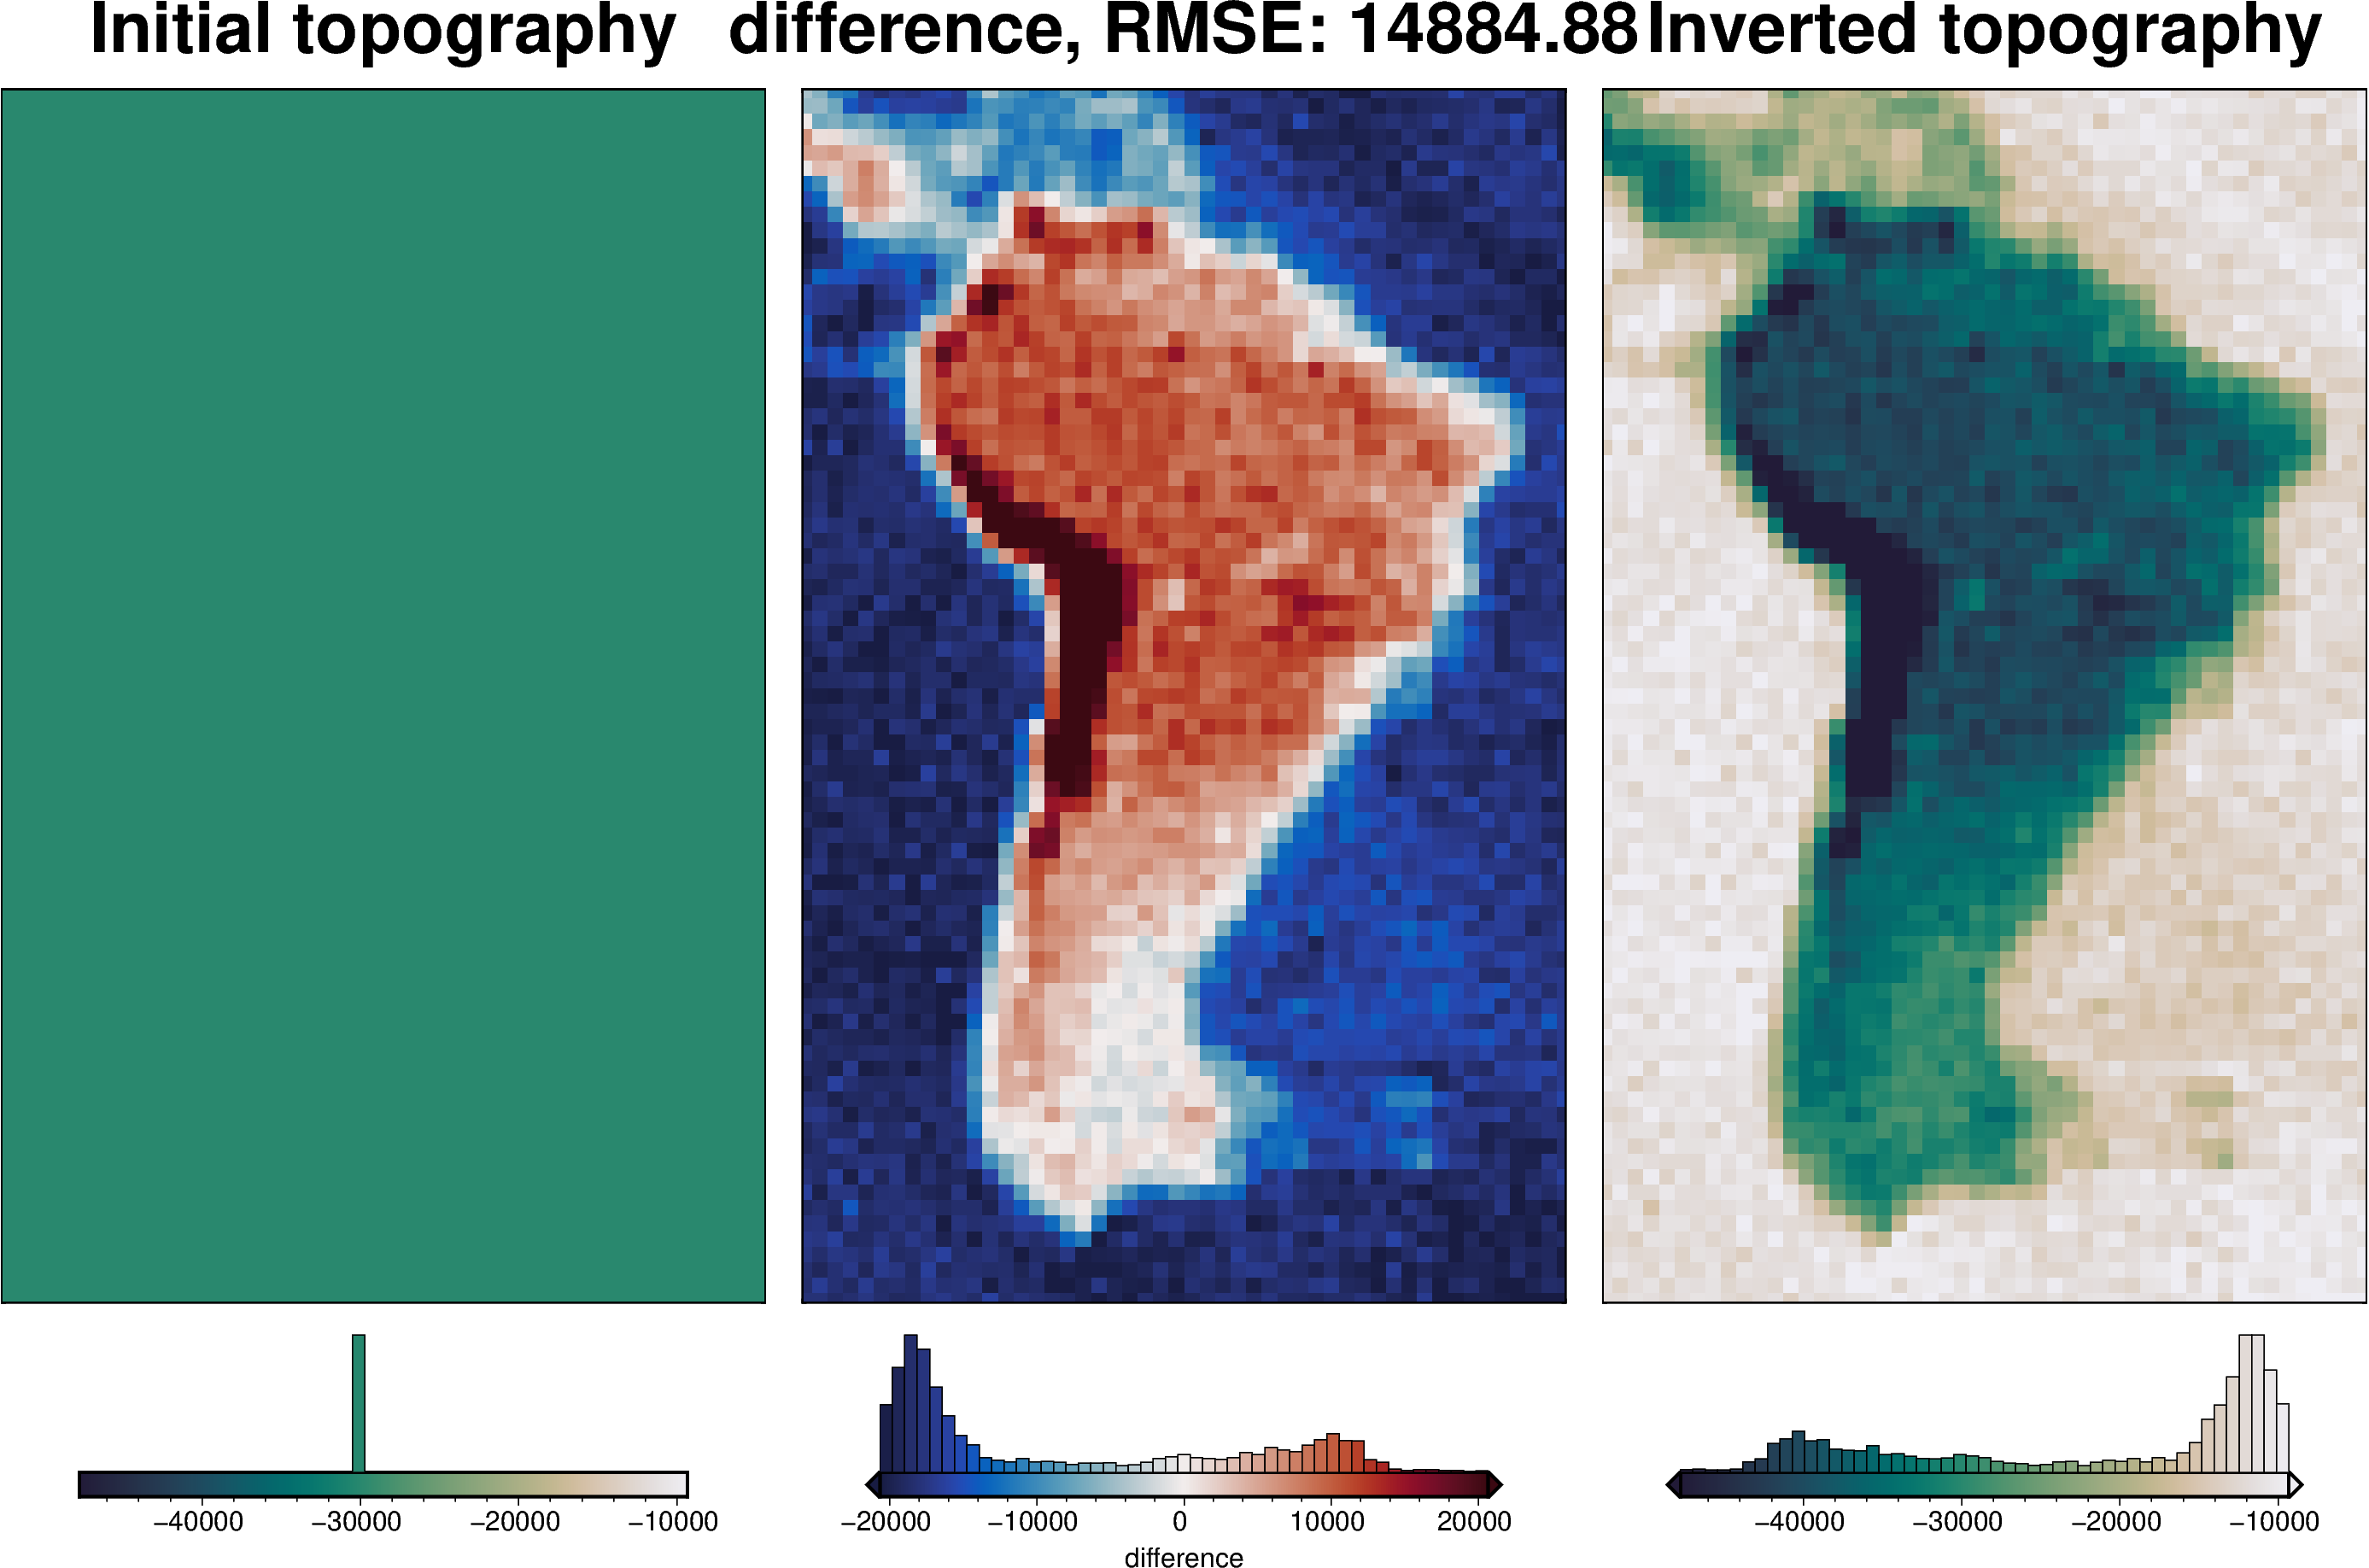

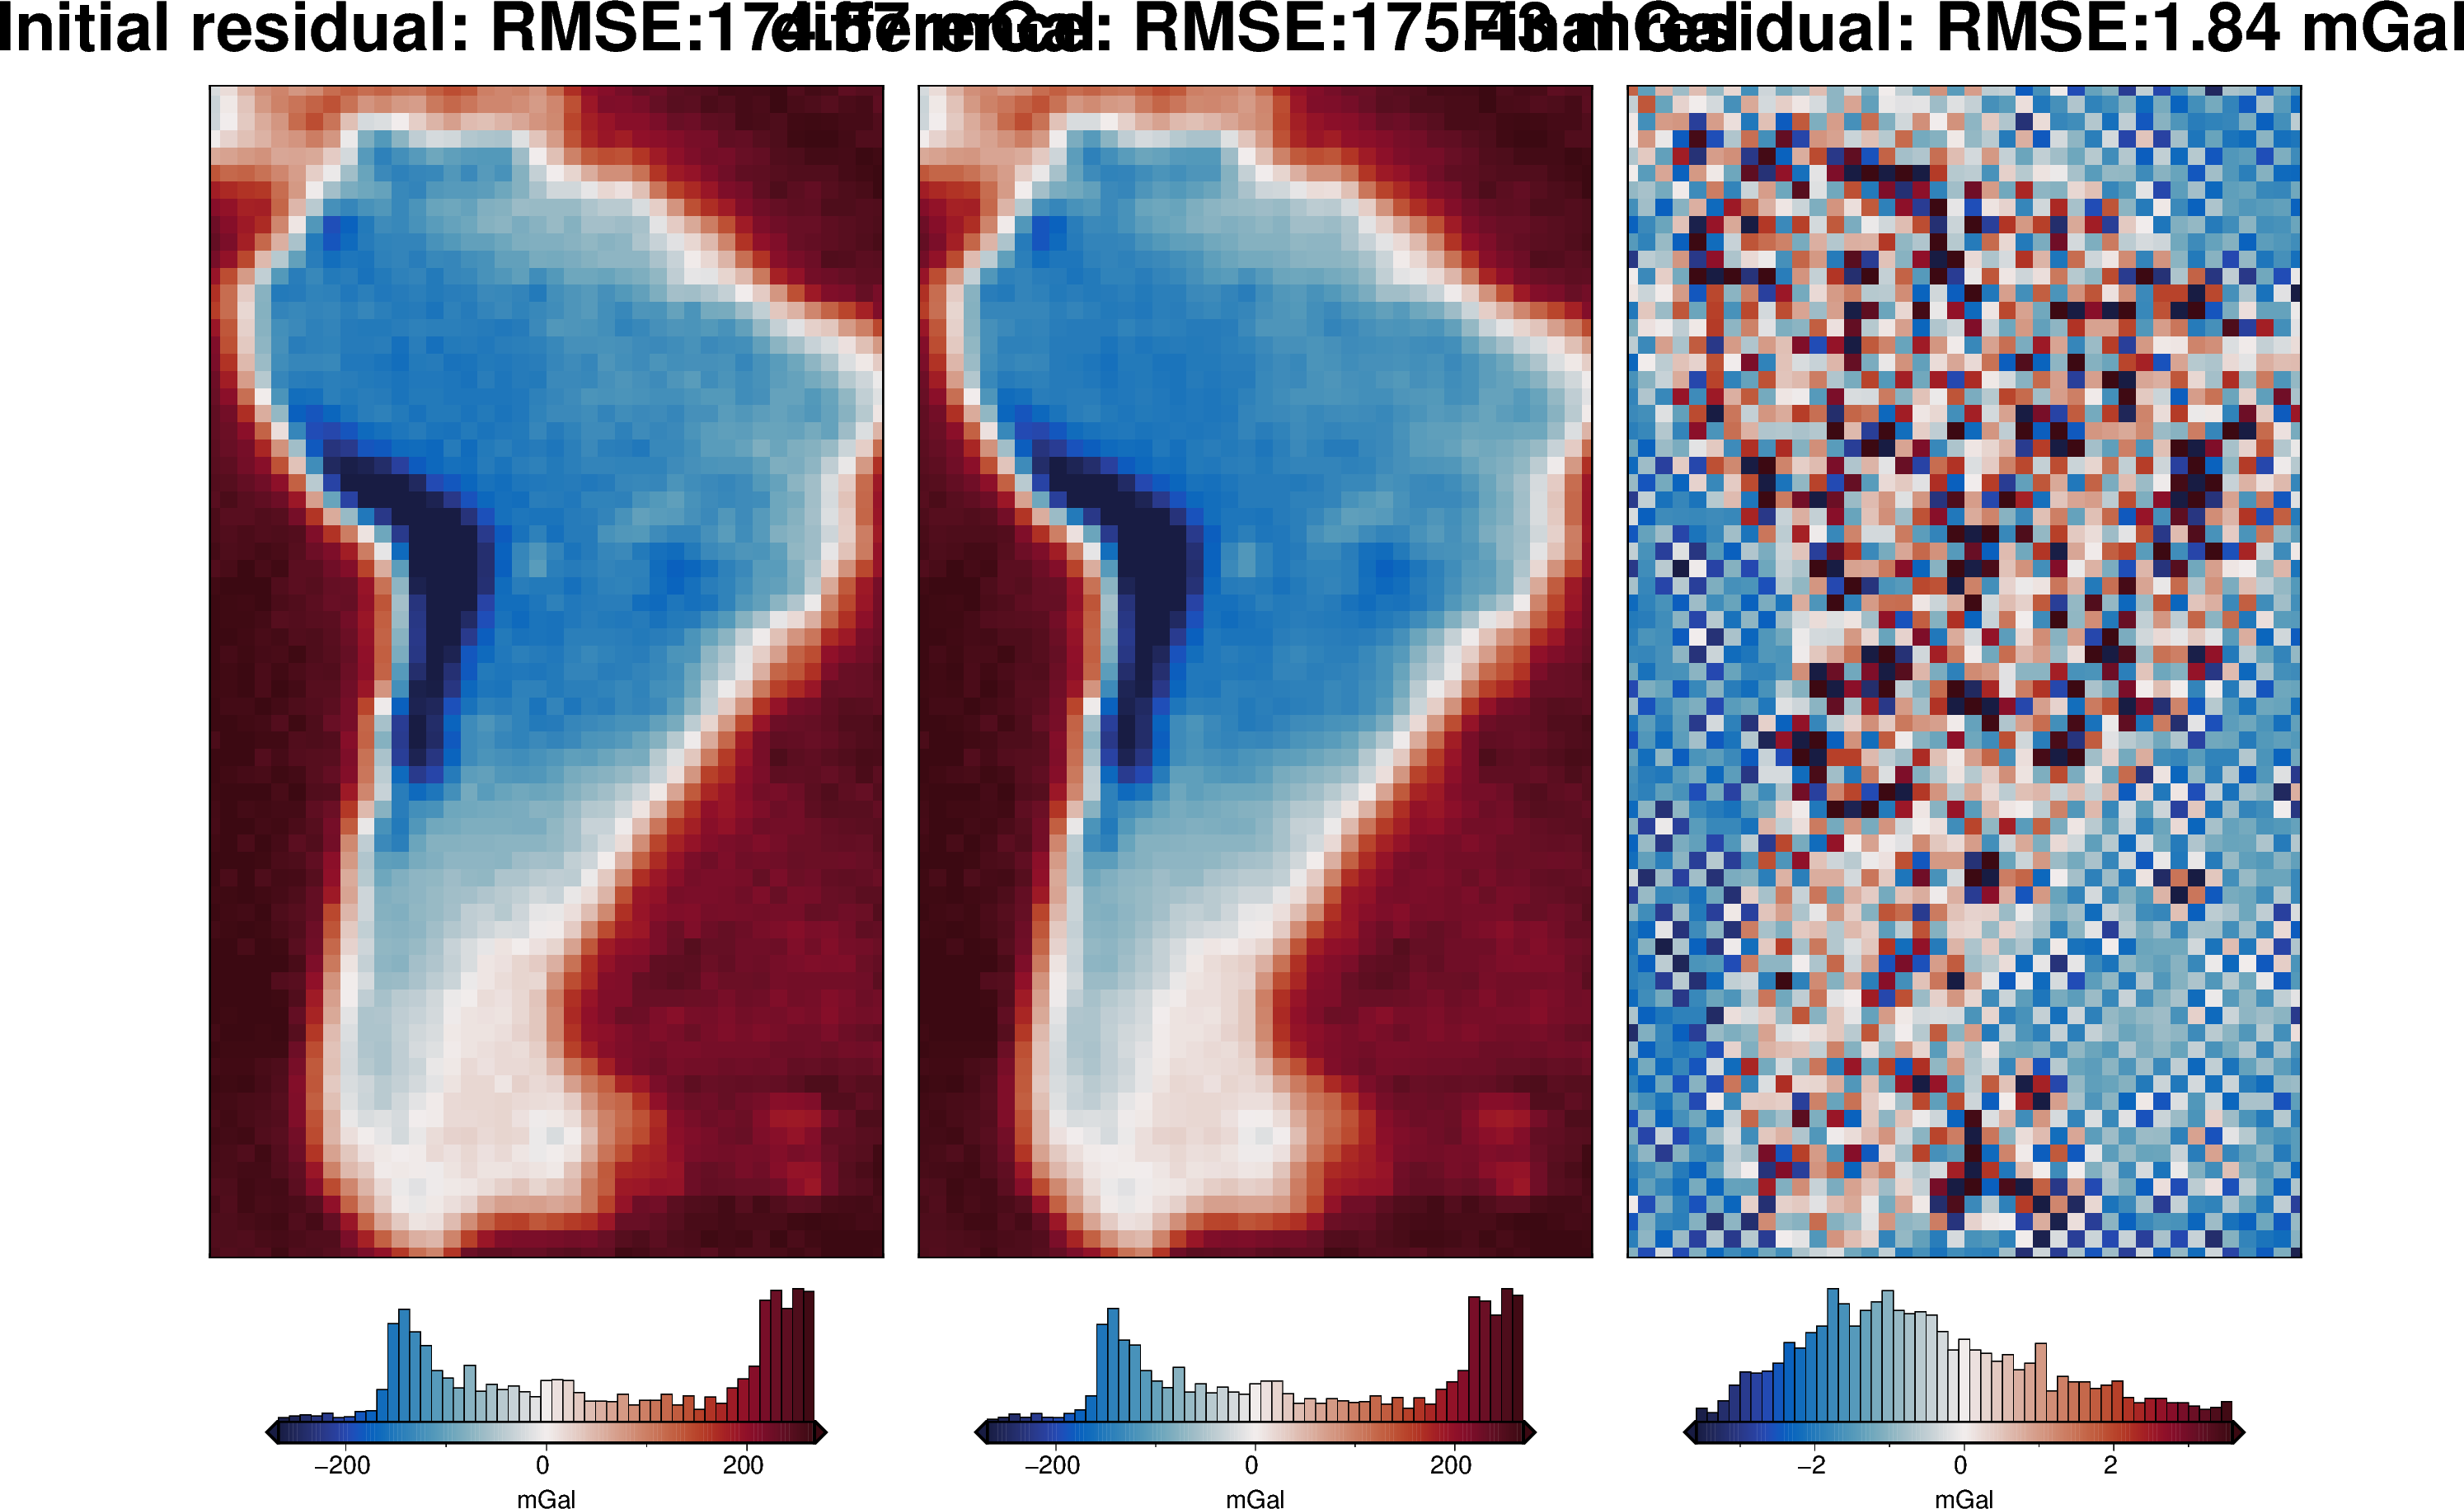

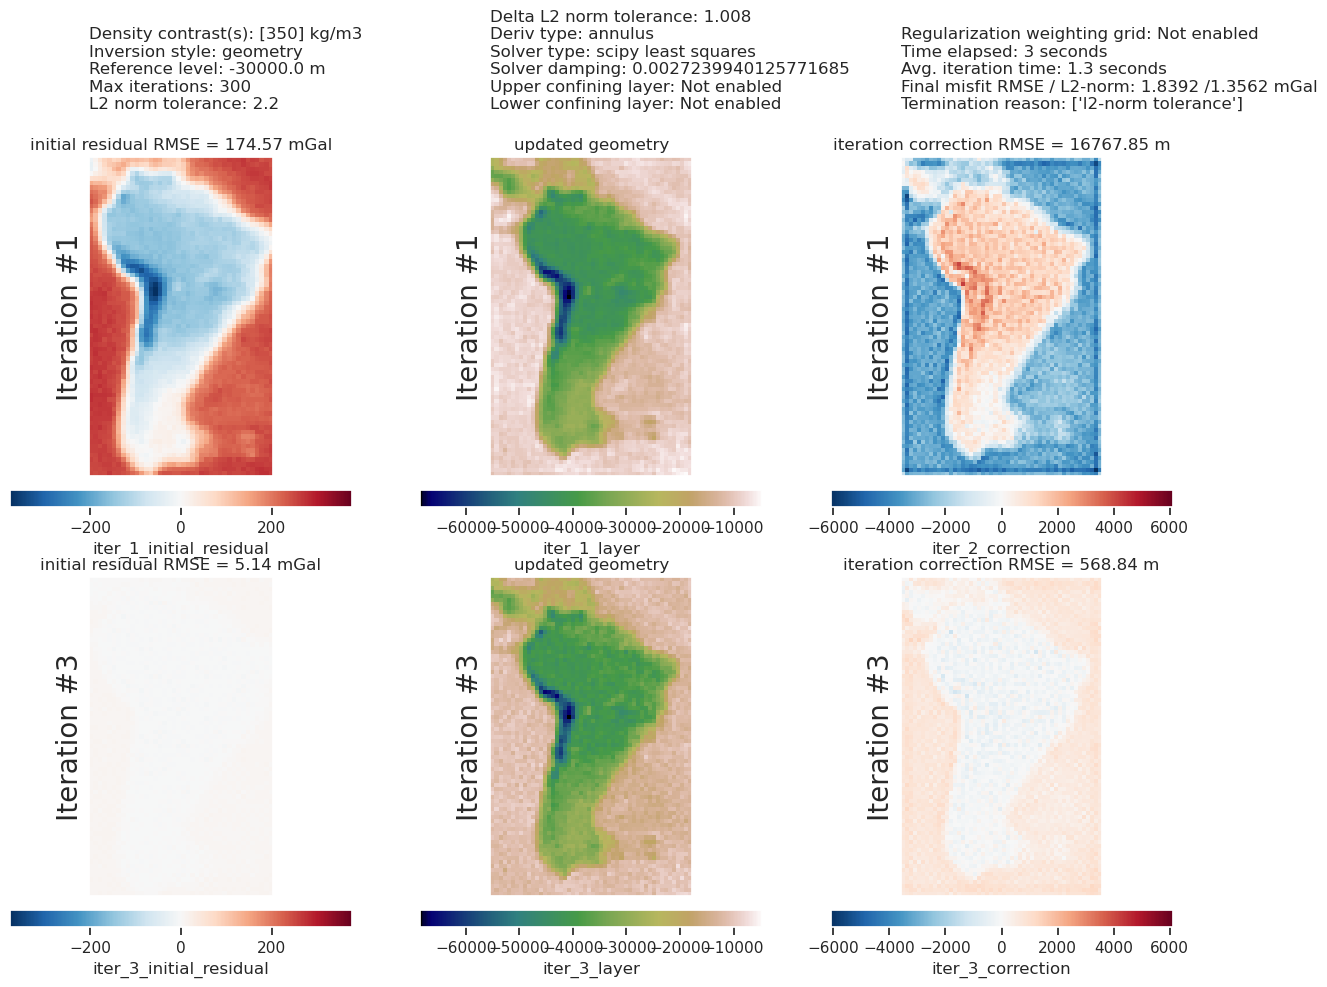

In [20]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

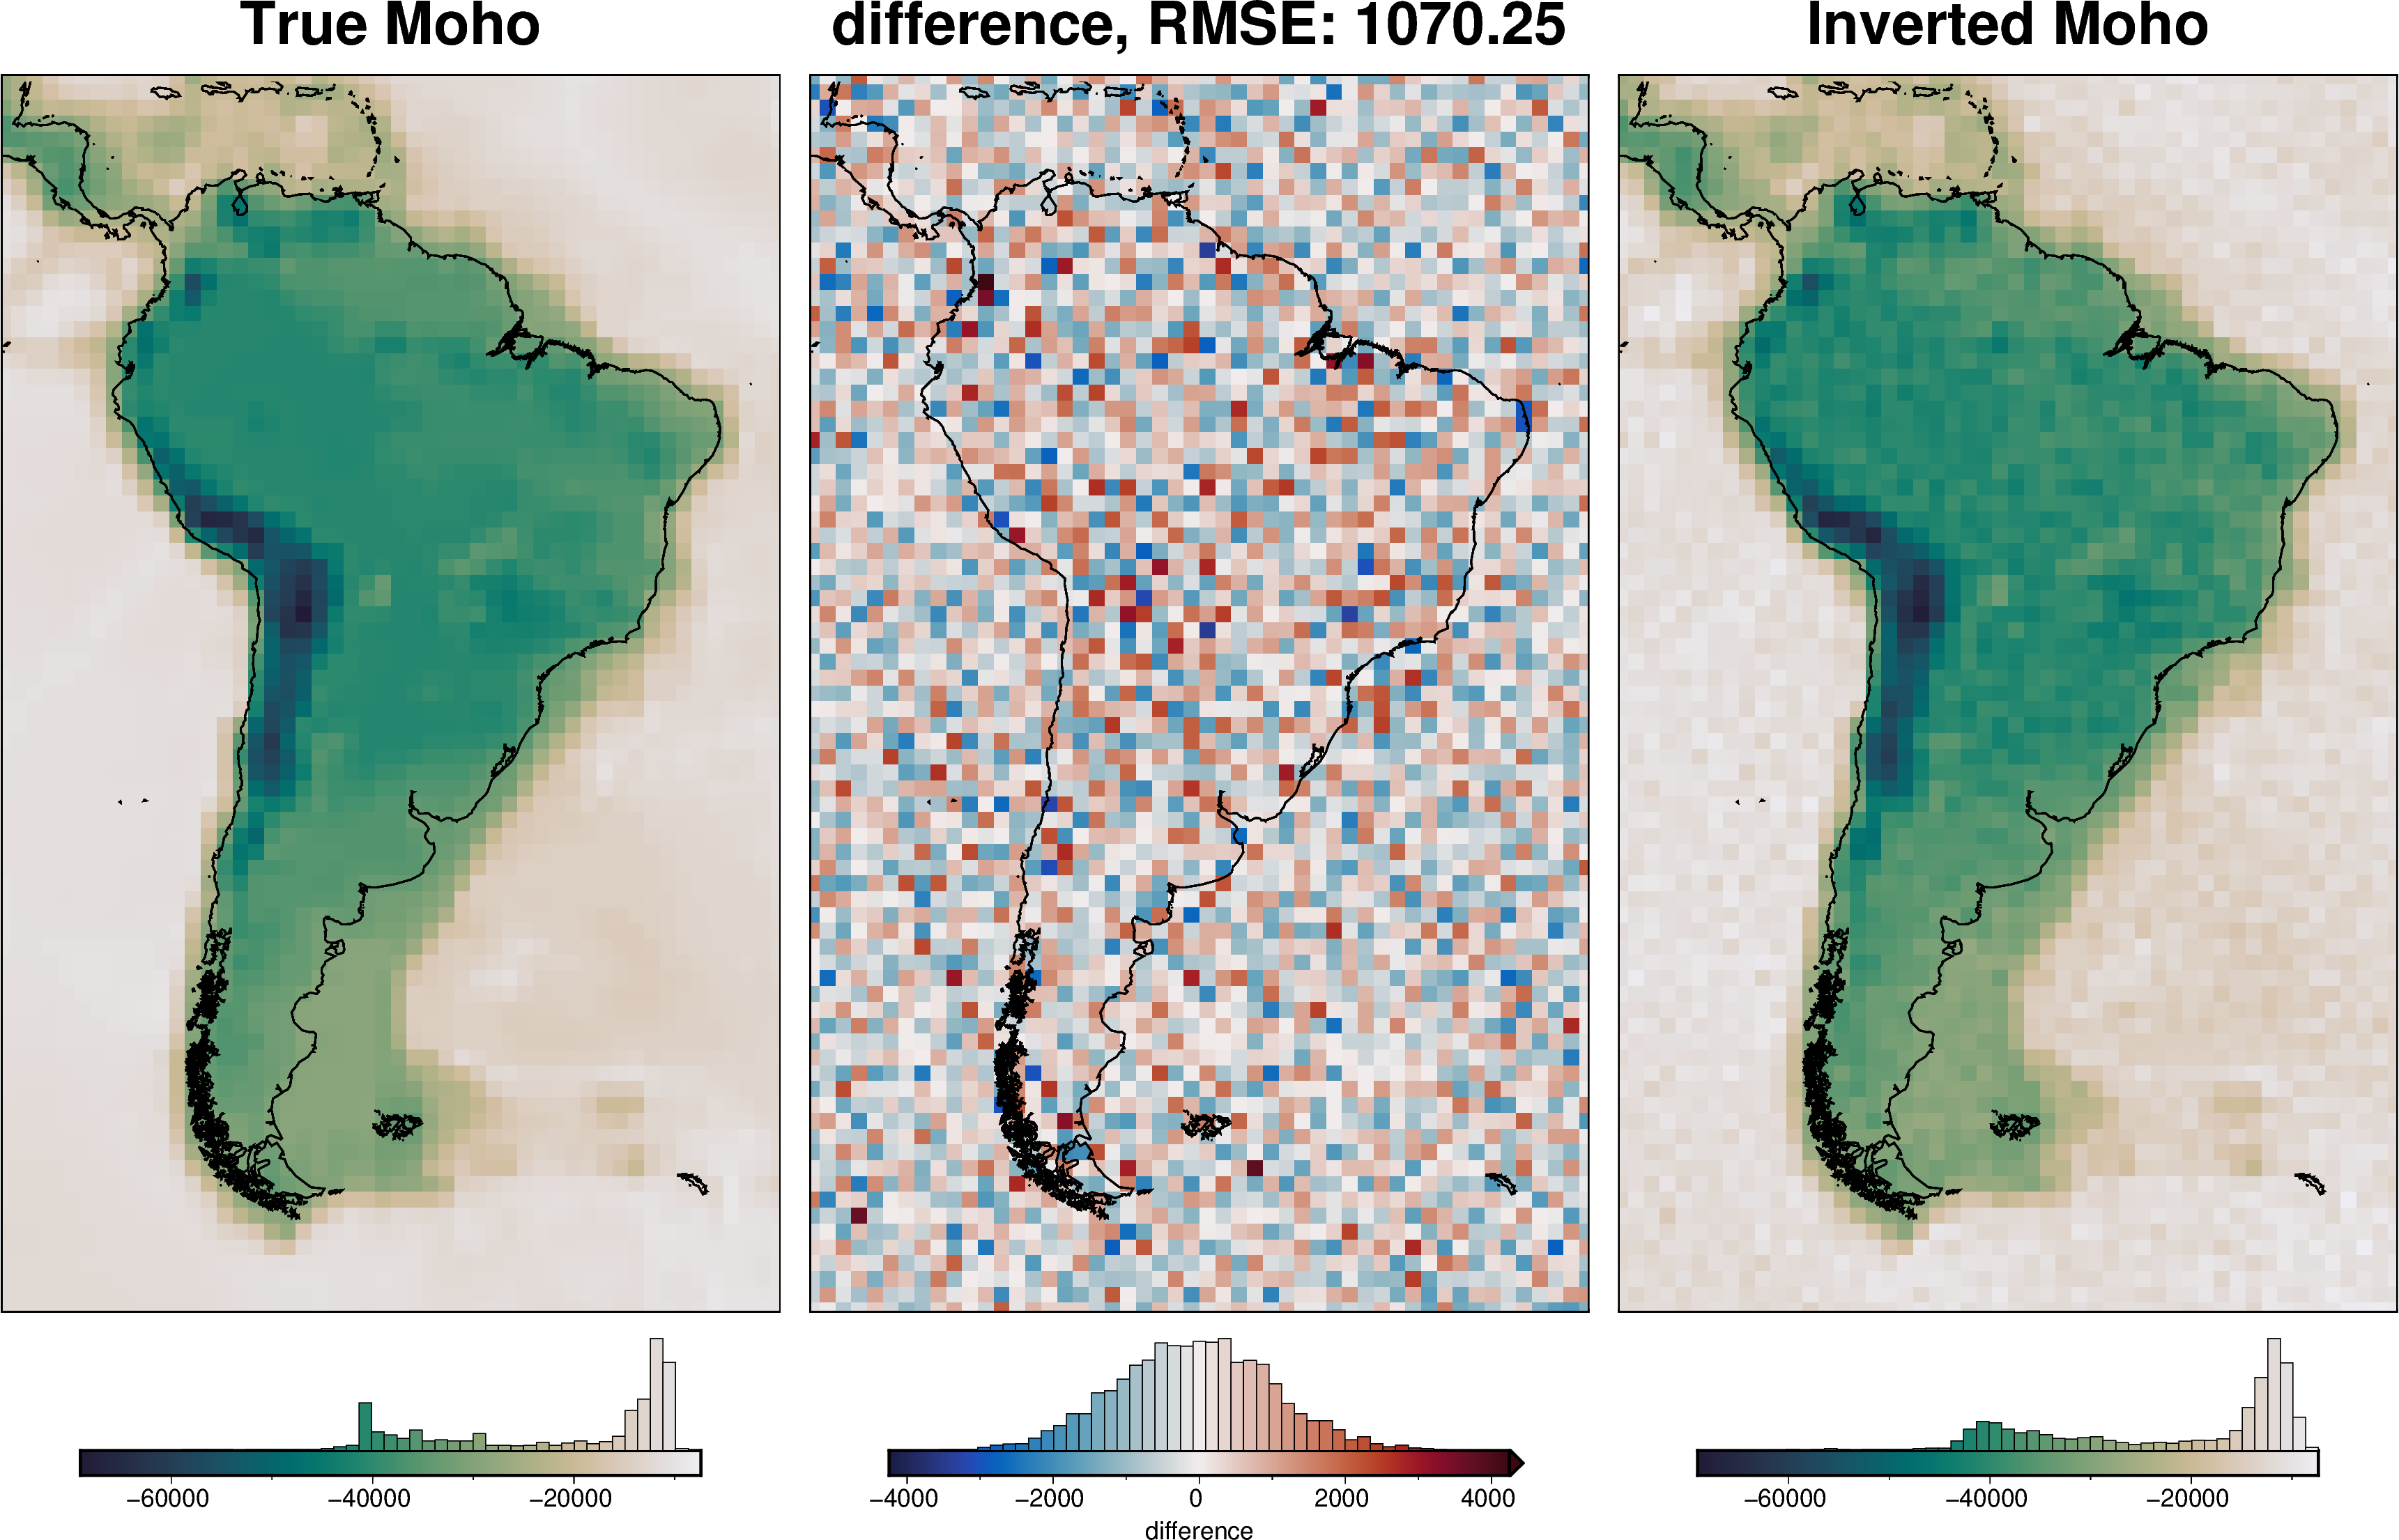

In [21]:
_ = ptk.grid_compare(
    true_moho,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    coast=True,
    coast_version="gmt",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 962.32 m


## Density / Reference level optimization

Now that we have a optimal damping value, we can perform an optimization to find the optimal values for density contrast and reference level. For these, we pick a range of possible values, and perform a hyperparameter optimization to find the best set of values.

In [23]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [24]:
inv.reinitialize_inversion()

In [25]:
# run the optimization for the zref and density
density_zref_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(200, 500),
    zref_limits=(-35e3, -20e3),
    n_trials=20,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs=dict(
        method="flat",
        region=region,
        spacing=spacing,
    ),
    plot_scores=False,
    fname="../tmp/uieda_CRUST1_zref_density_optimization",
)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [26]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_zref_density_optimization_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

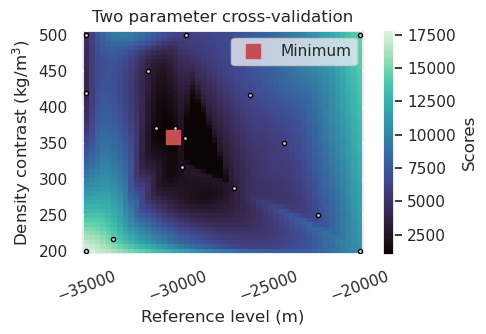

In [27]:
fig = invert4geom.plot_2_parameter_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

In [28]:
best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

print(f"Optimal zref: {best_zref / 1e3:.1f} km")
print(f"True zref: {true_zref / 1e3:.1f} km")
print(f"Optimal density contrast: {best_density_contrast:.1f} kg/m³")
print(f"True density contrast: {true_density_contrast:.1f} kg/m³")

Optimal zref: -30.3 km
True zref: -30.0 km
Optimal density contrast: 358.0 kg/m³
True density contrast: 350.0 kg/m³


In [29]:
# we can also access the optimally-determined values through the `inv` object
print(f"Solver damping: {inv.solver_damping}")
print(f"Zref: {inv.model.zref / 1e3:.1f} km")
print(f"Density contrast: {inv.model.density_contrast:.1f} kg/m³")

Solver damping: 0.0027239940125771685
Zref: -30.3 km
Density contrast: 358.0 kg/m³


The above plot shows the results of the cross validation and is equivalent to Figure 7b in the paper. The optimal values they report are zref = 30 km and density contrast = 350 kg/m-3, which are roughly the same as the values we find. The main difference is that they used a grid-search approach, testing evenly-spaced values between -35 and -20 km, and between 500 and 200 kg/m-3. We instead used an optimization approach, where the parameters space is smartly searched based on the scores of the past trials. As you can see, this allows us to find the optimal values in far fewer trials. Here we used 20 trials, compared to the 49 trials used in the paper.

We also support the grid-search approach, which can be enabled with `grid_search=True` in the above function.

### Plot results

The below plots show the inversion results used the optimal damping, density contrast, and reference level values. 

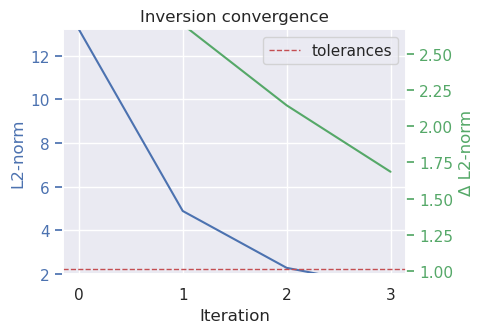

In [30]:
inv.plot_convergence()

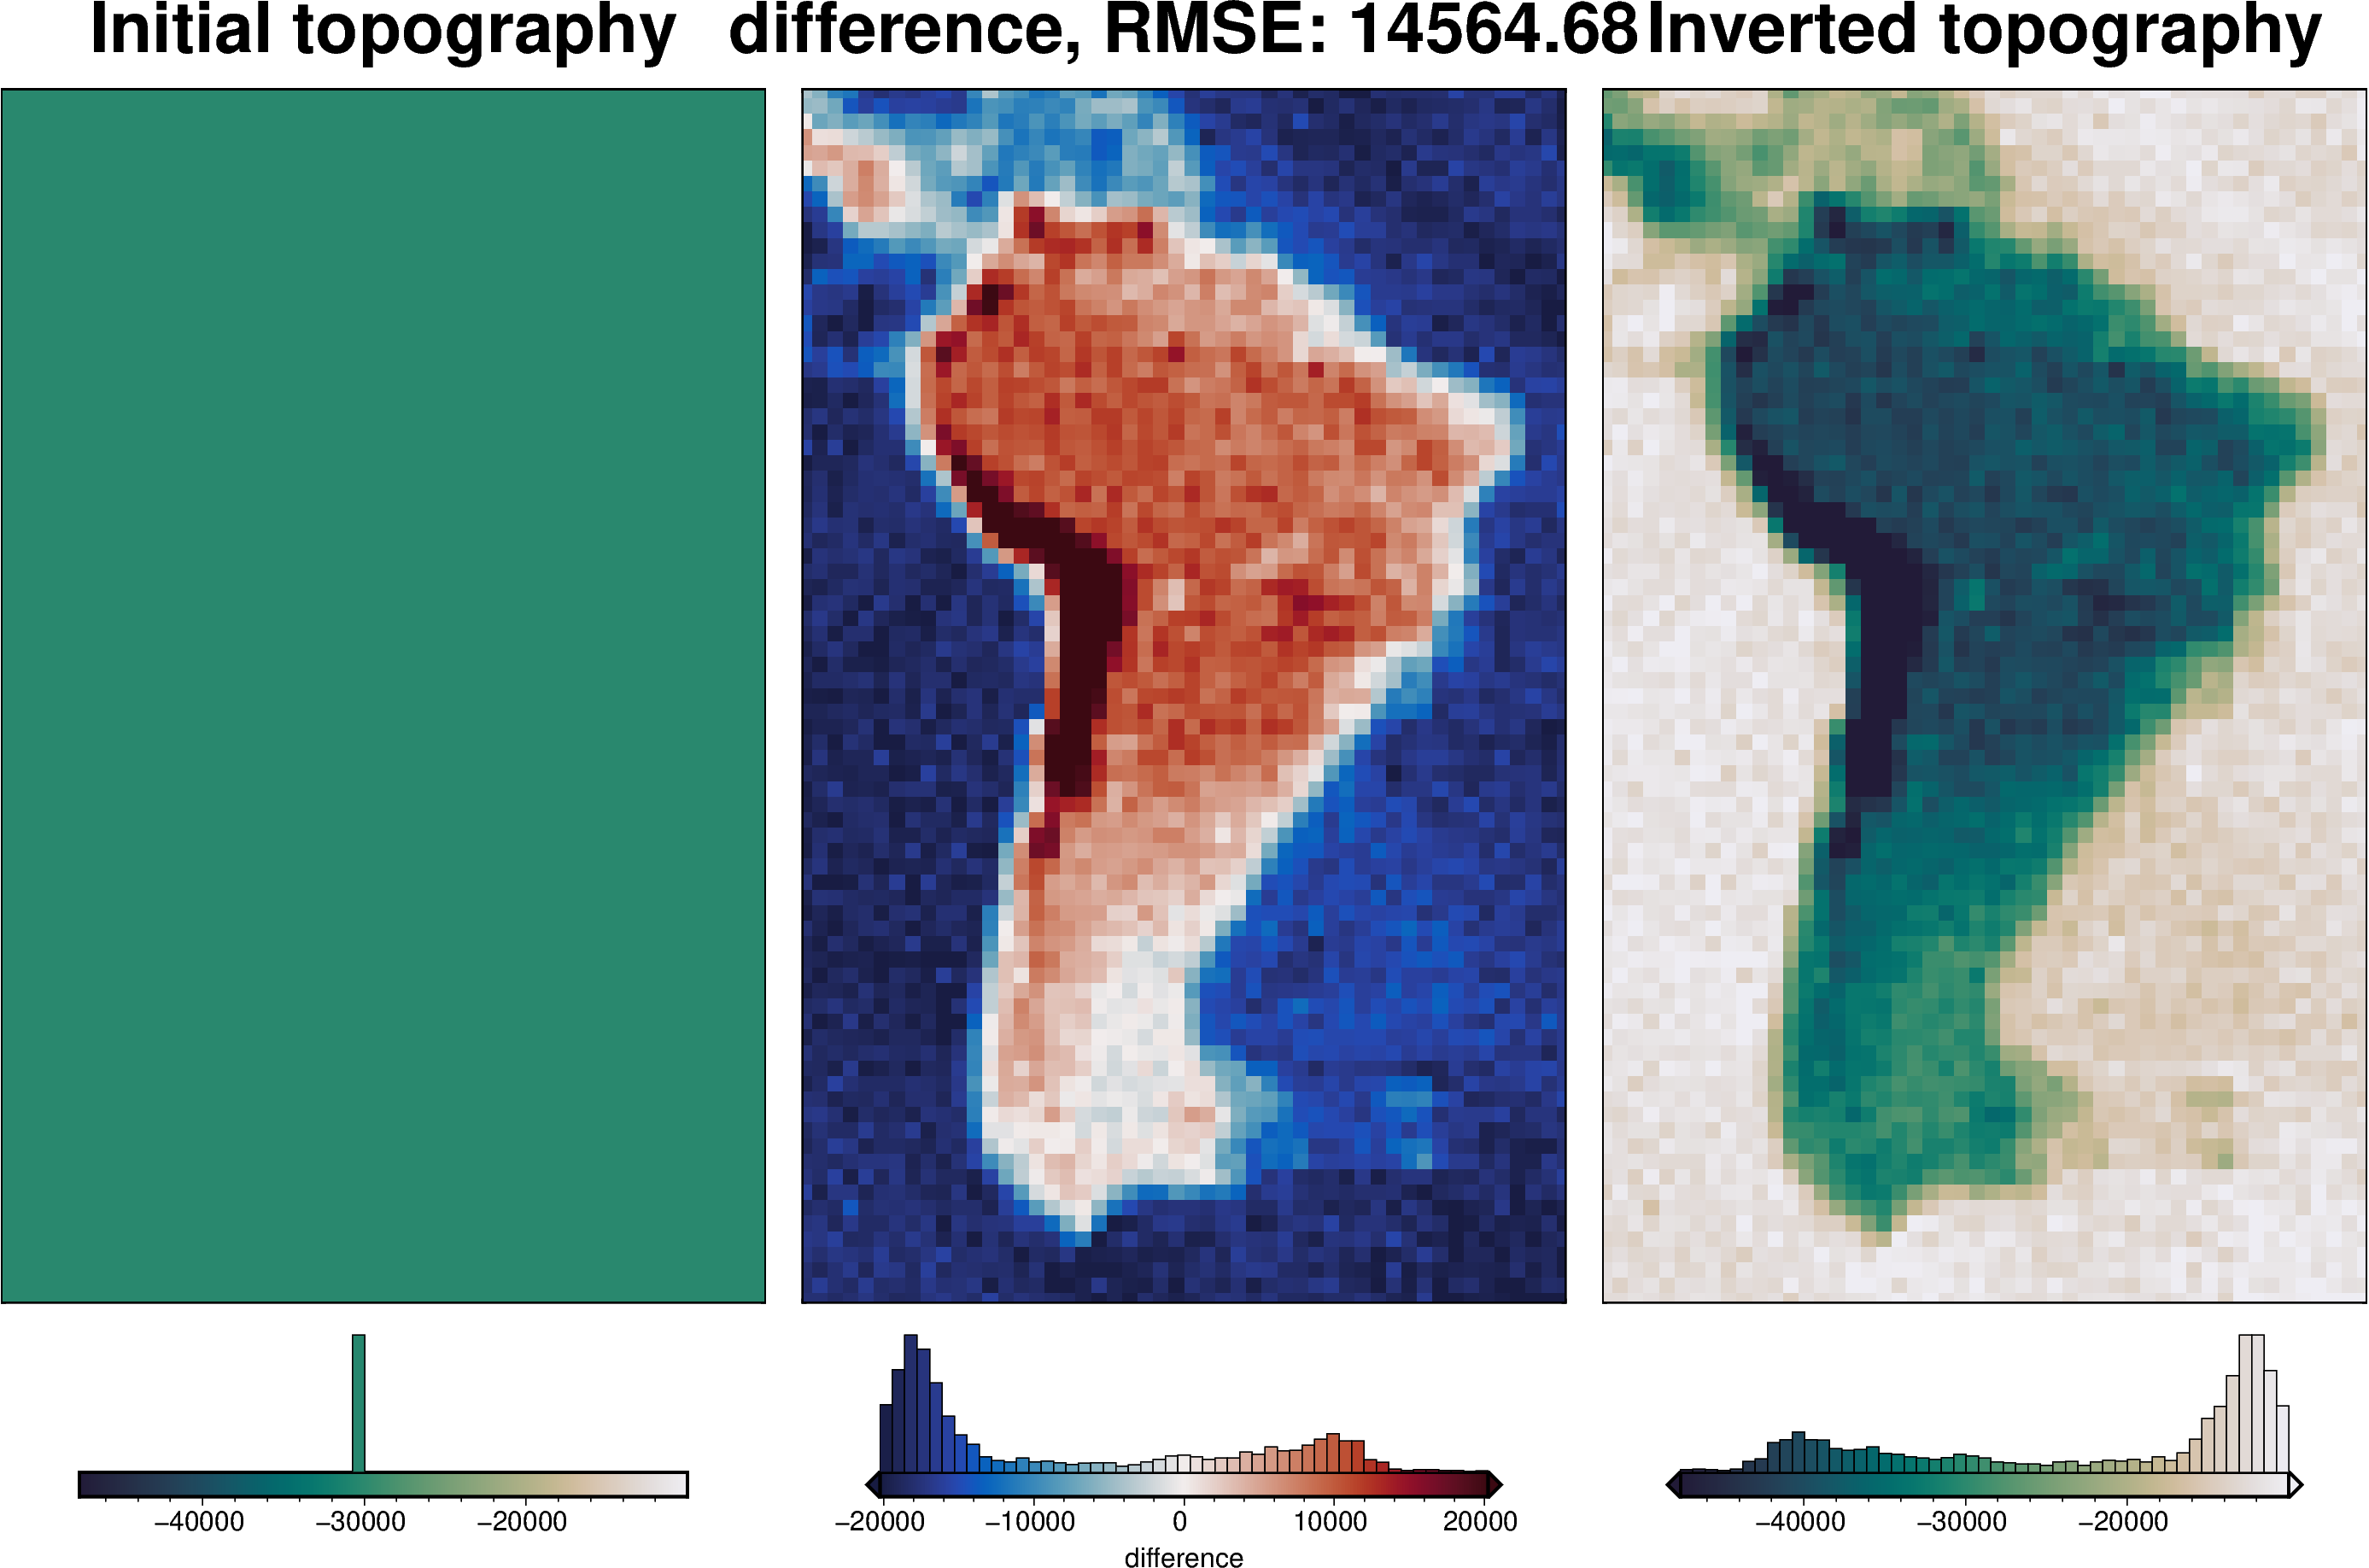

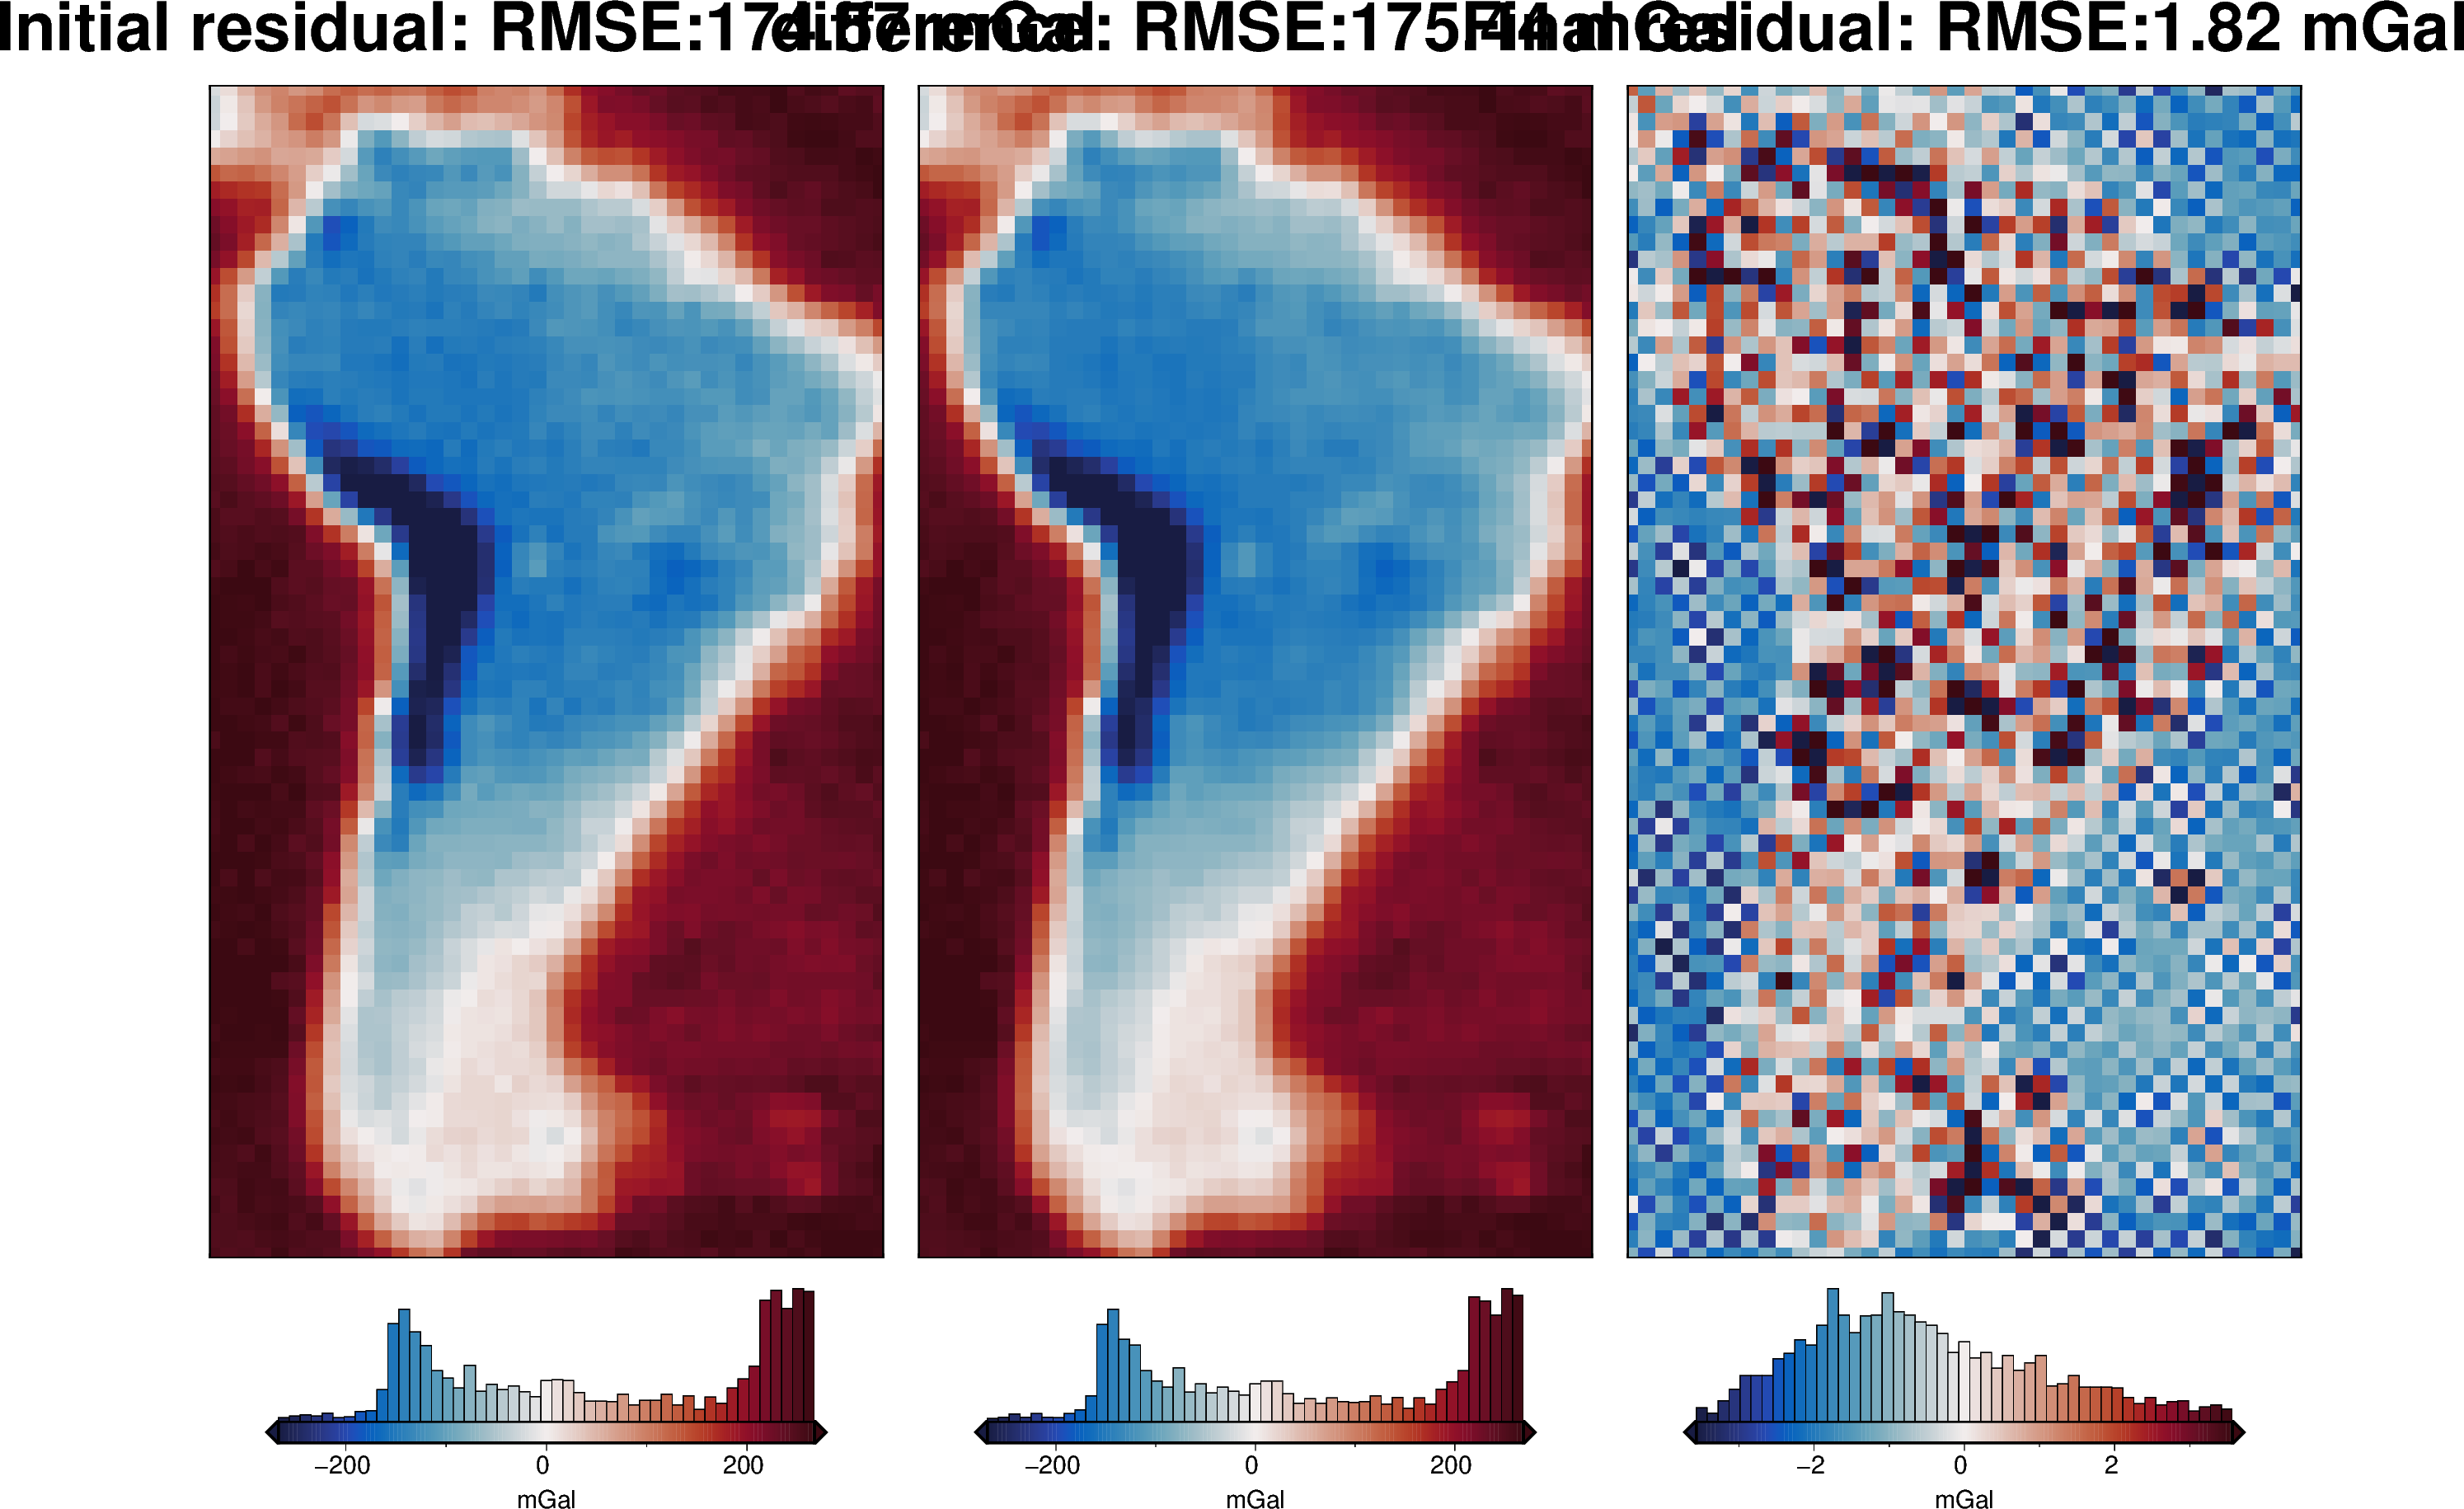

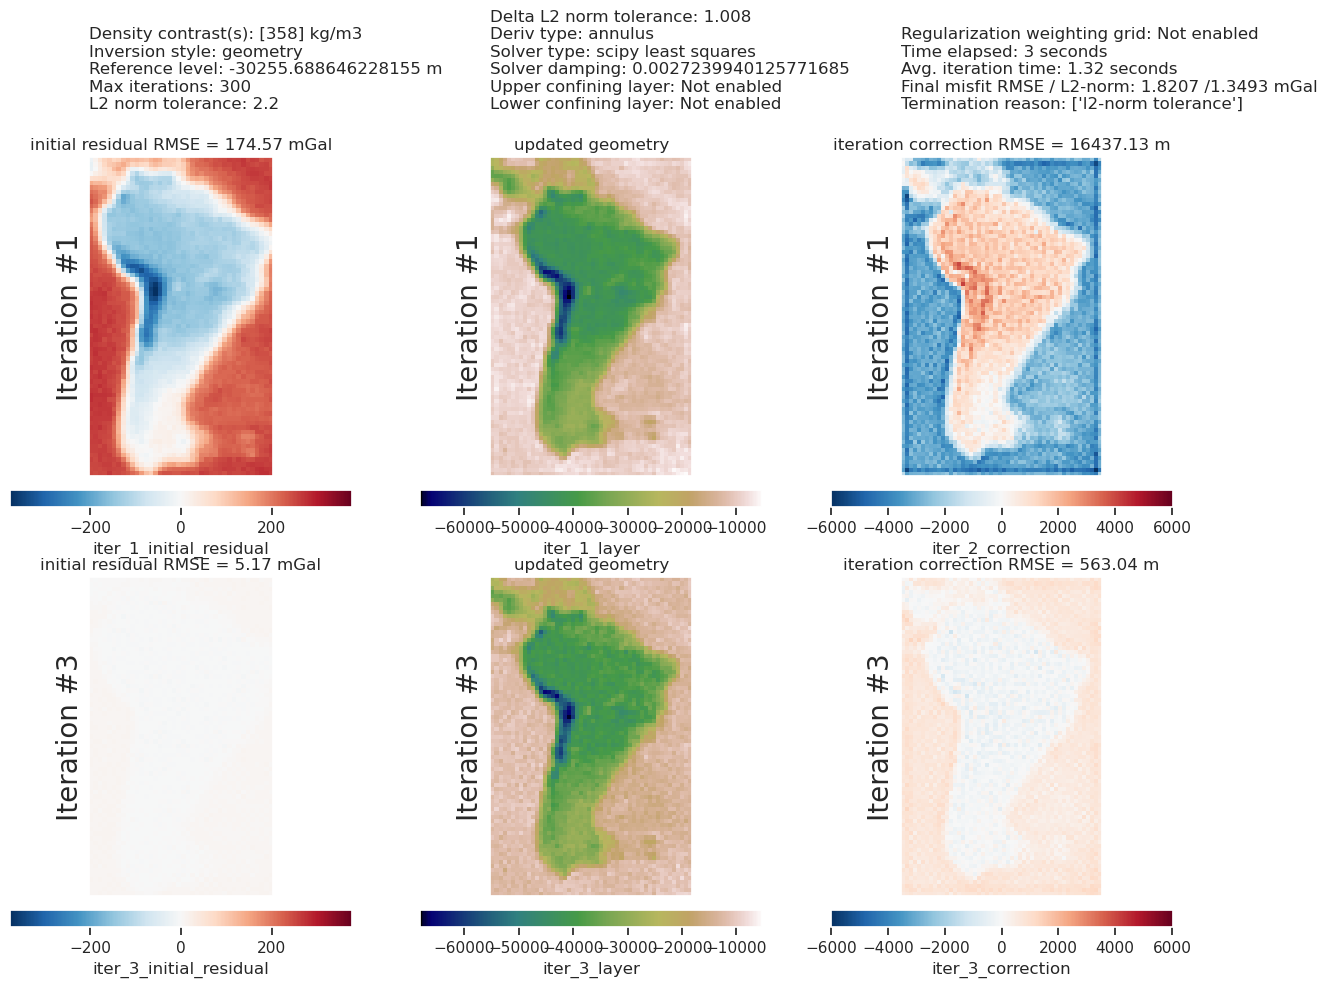

In [31]:
inv.plot_inversion_results(iters_to_plot=2)

The second plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 7g in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 3 iterations due to the inversion reaching the set L2-norm tolerance. 

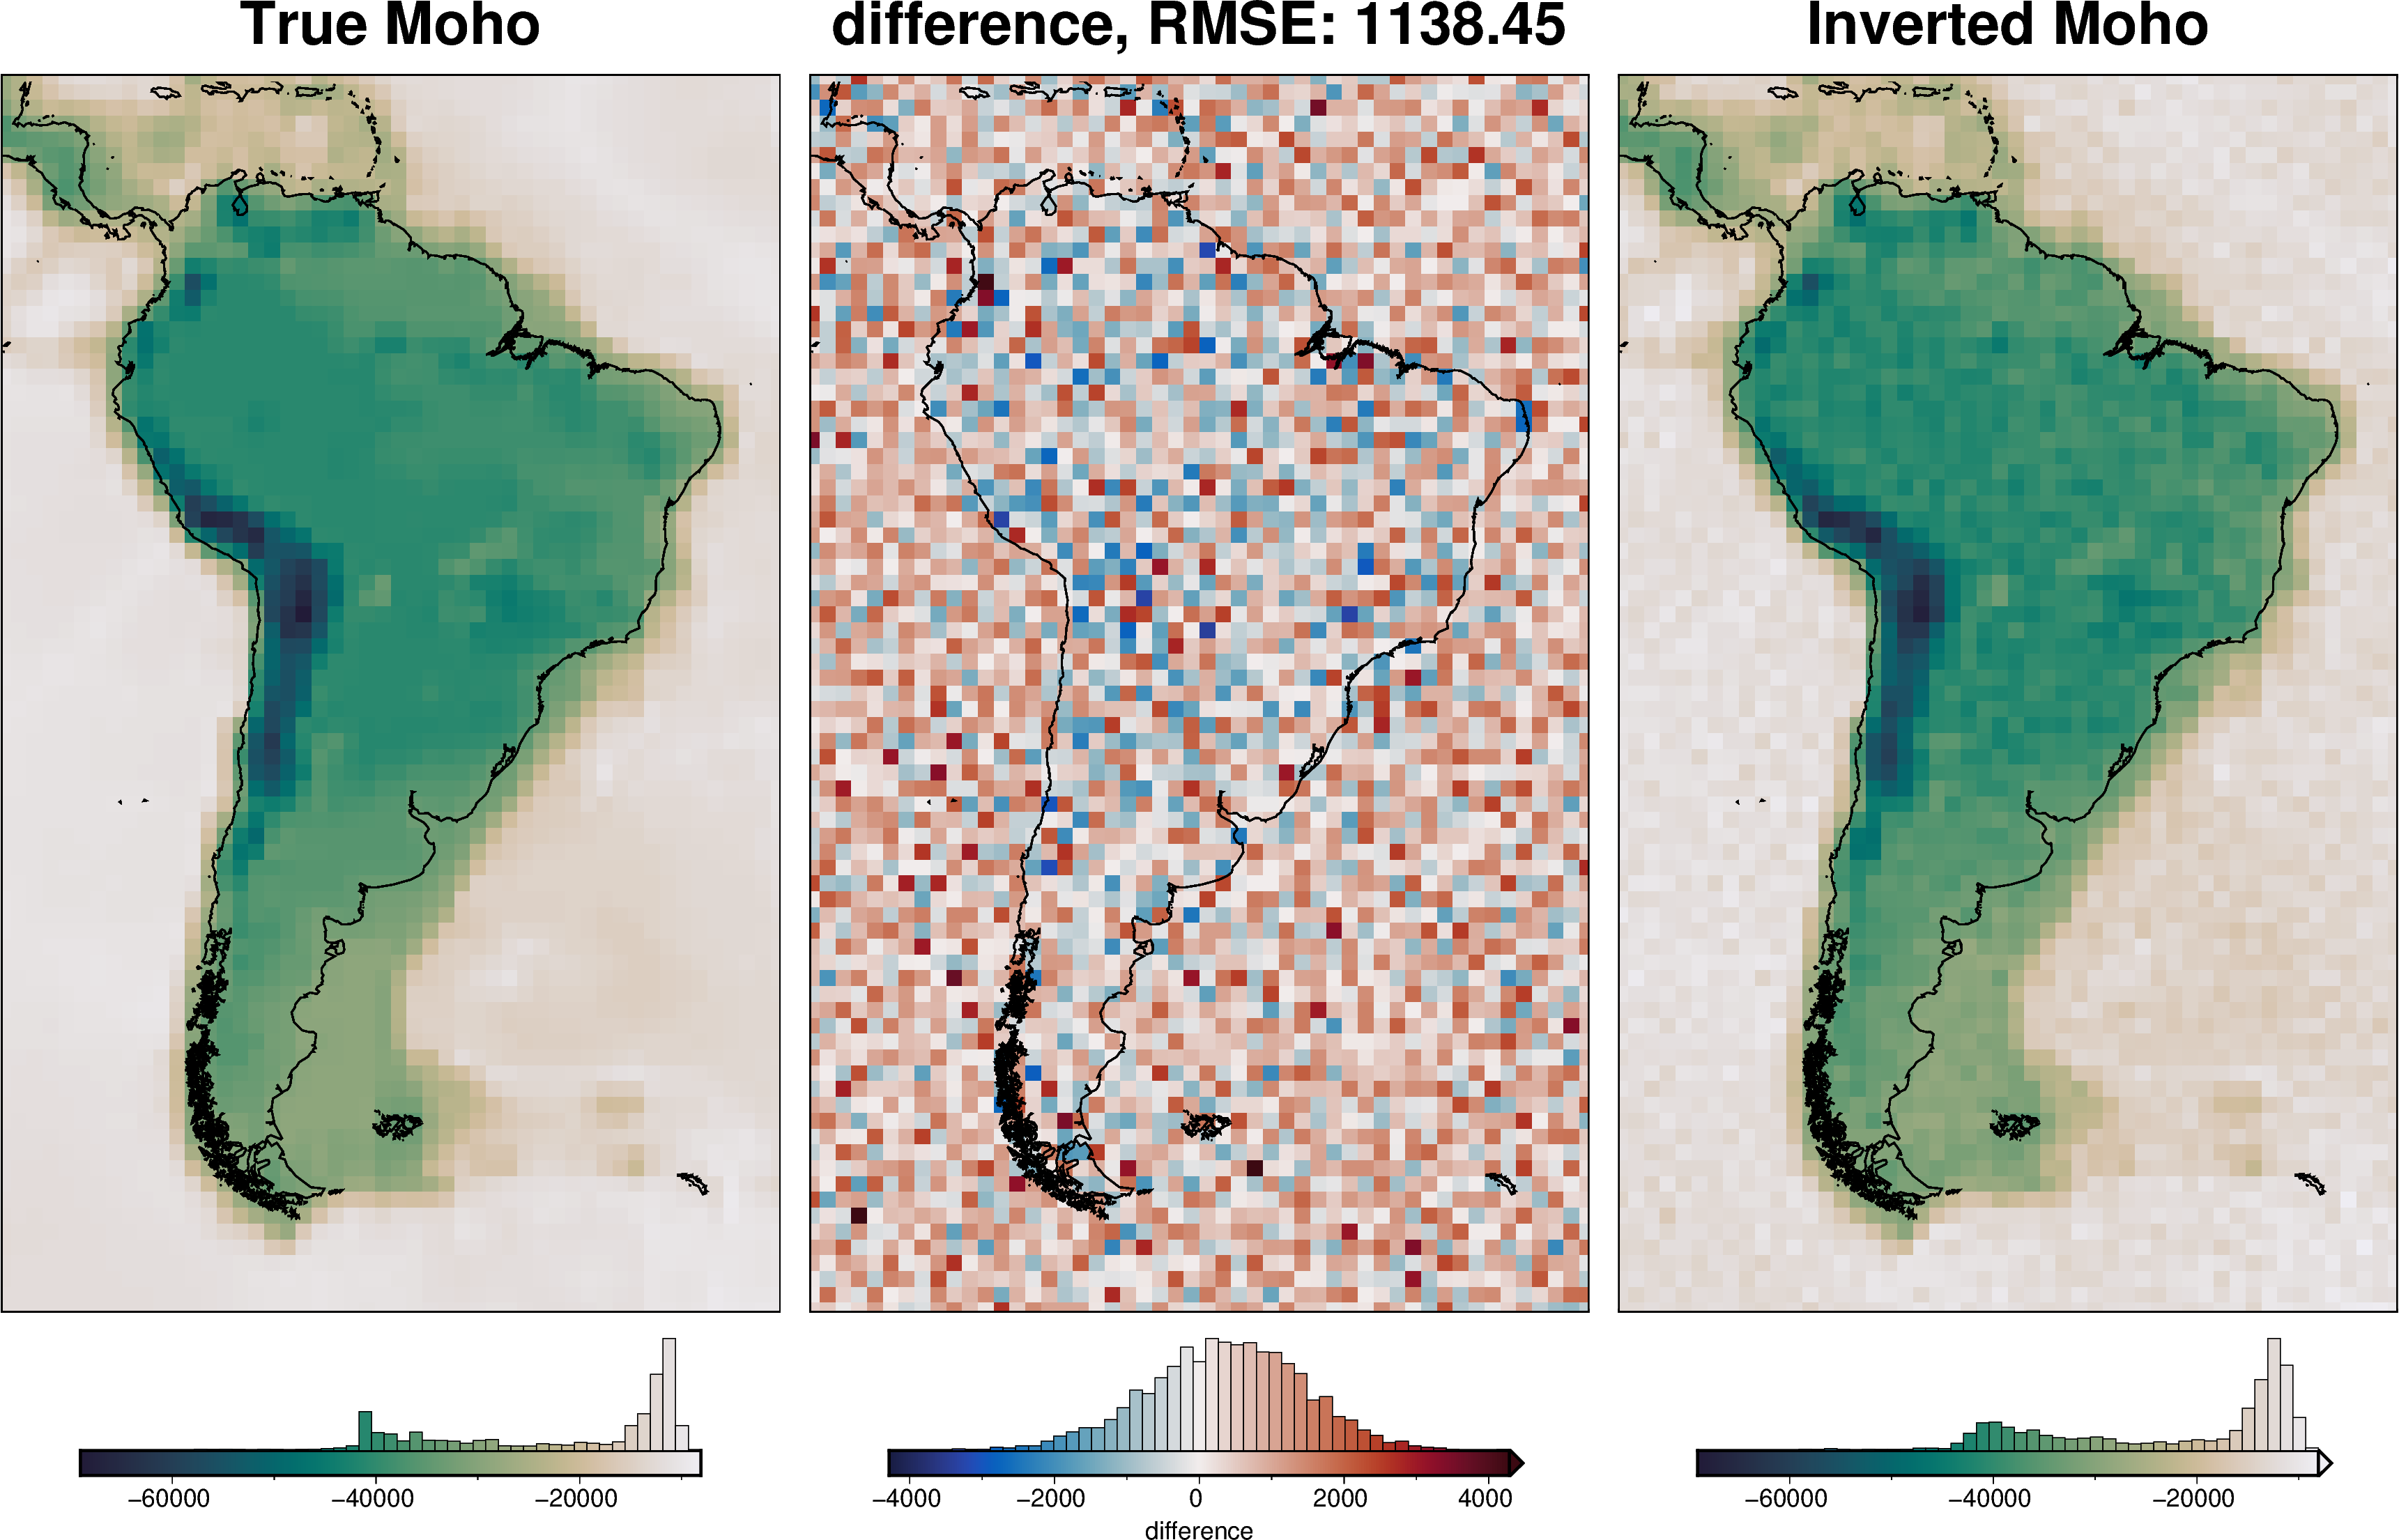

In [32]:
_ = ptk.grid_compare(
    true_moho,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    coast=True,
)

The above plot shows the difference between the true and inverted topography and is equivalent to Figure 6d in the paper. The colorbar histogram of the middle subplot is equivalent to Figure 6f. The errors are normally distributed around ~0, with a RMS of ~1100 m.

In [33]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 976.60 m


## Repeat with adhering to constraints
The above inversions only used the constraint points as a means to perform the cross validation. Below we will create a starting model from these points and attempt to make the inversion adhere to the constraints.

### Starting model

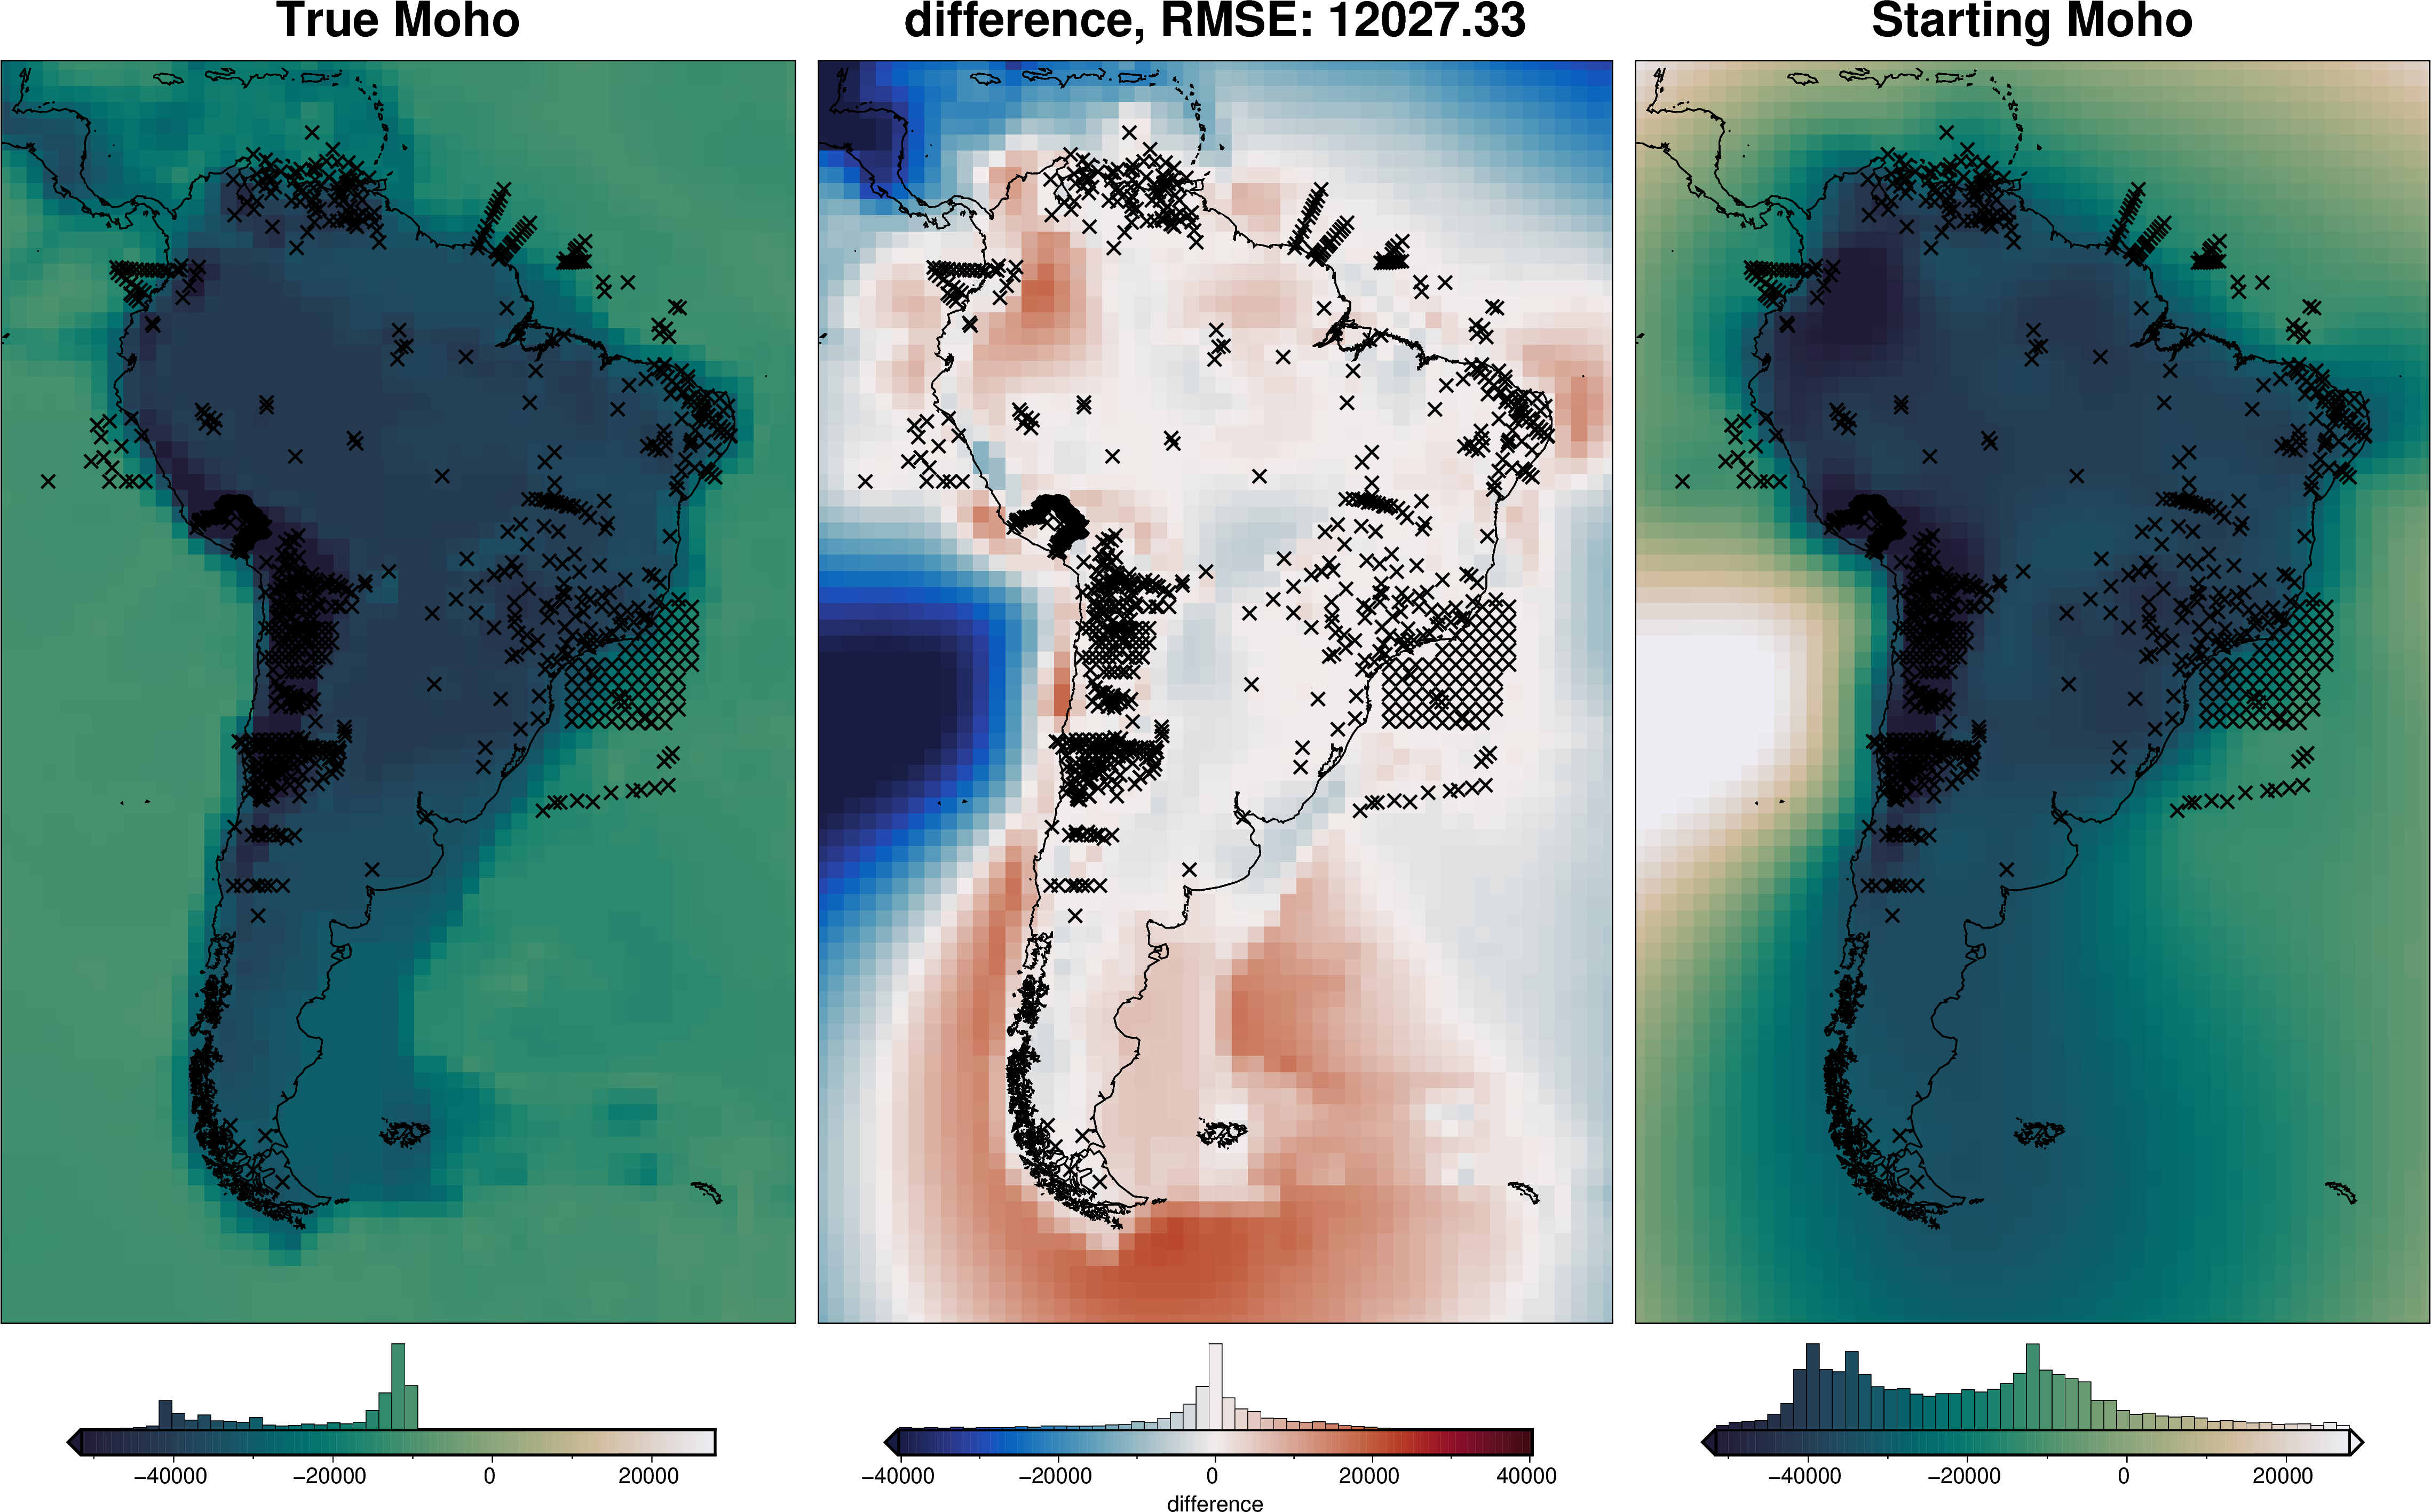

In [34]:
# grid the sampled values using verde
starting_topography = invert4geom.create_topography(
    method="splines",
    region=grav_data.region,
    spacing=grav_data.spacing,
    constraints_df=constraint_points,
    dampings=None,  # np.logspace(-20, 0, 4),
)

_ = ptk.grid_compare(
    true_moho,
    starting_topography.upward,
    fig_height=20,
    region=grav_data.region,
    grid1_name="True Moho",
    grid2_name="Starting Moho",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
    coast=True,
)

In [35]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    starting_topography.upward,
    "starting_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.starting_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 270.85 m


### Use a weighting grid
To ensure the inversion doesn't alter the starting model at the constraint points, where we know what the Moho elevation is, we can use a weighting grid. This scales each iterations correction values to be 0 at the constraint points. It's a good idea to redo the damping parameter CV when using this since the optimal damping value will likely change when you're using a weighting grid.

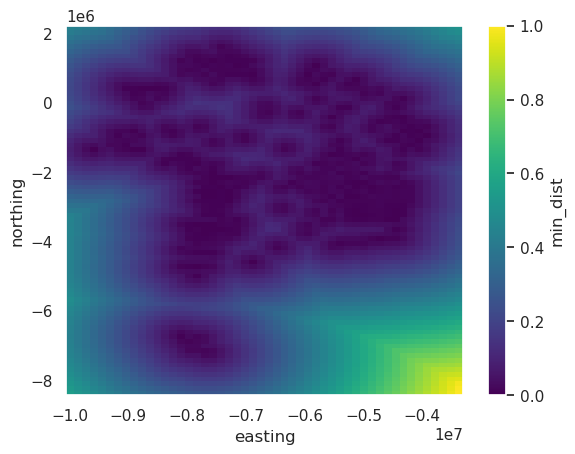

In [36]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = invert4geom.normalized_mindist(
    constraint_points,
    model.starting_topography,
    low=0,
    high=1,
)
weighting_grid.plot()

### Damping CV

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

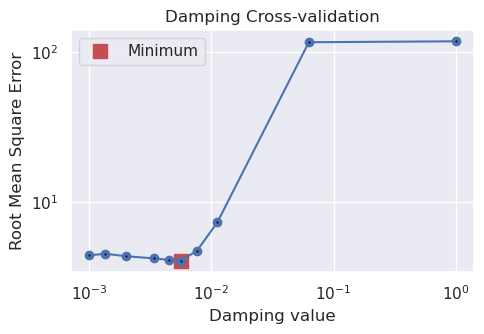

In [37]:
weighted_results = invert4geom.run_inversion_workflow(
    grav_ds=grav_data,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    run_damping_cv=True,
    constraints_df=constraint_points,
    density_contrast=best_density_contrast,
    zref=best_zref,
    fname="../tmp/uieda_CRUST1_with_starting_model",
    starting_topography=starting_topography,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "max_iterations": 300,
        "l2_norm_tolerance": 2.2,
        "delta_l2_norm_tolerance": 1.008,
        "apply_weighting_grid": True,
        "weighting_grid": weighting_grid,
    },
    damping_cv_kwargs={
        "damping_limits": (0.001, 1),
        "n_trials": 10,
        "n_startup_trials": 5,
        "plot_scores": True,
    },
)

In [38]:
# to re-load the inversion results from the saved pickle file
name = "../tmp/uieda_CRUST1_with_starting_model.pickle"
with pathlib.Path(name).open("rb") as f:
    weighted_results = pickle.load(f)

In [39]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    weighted_results.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 272.49 m


The inversion error without a starting model was ~1100 m, and 1050 m at constraint points. Including a starting model and weighting grid reduced the error at constraint points to 230 m, while the overall error of the inverted Moho remained similar.

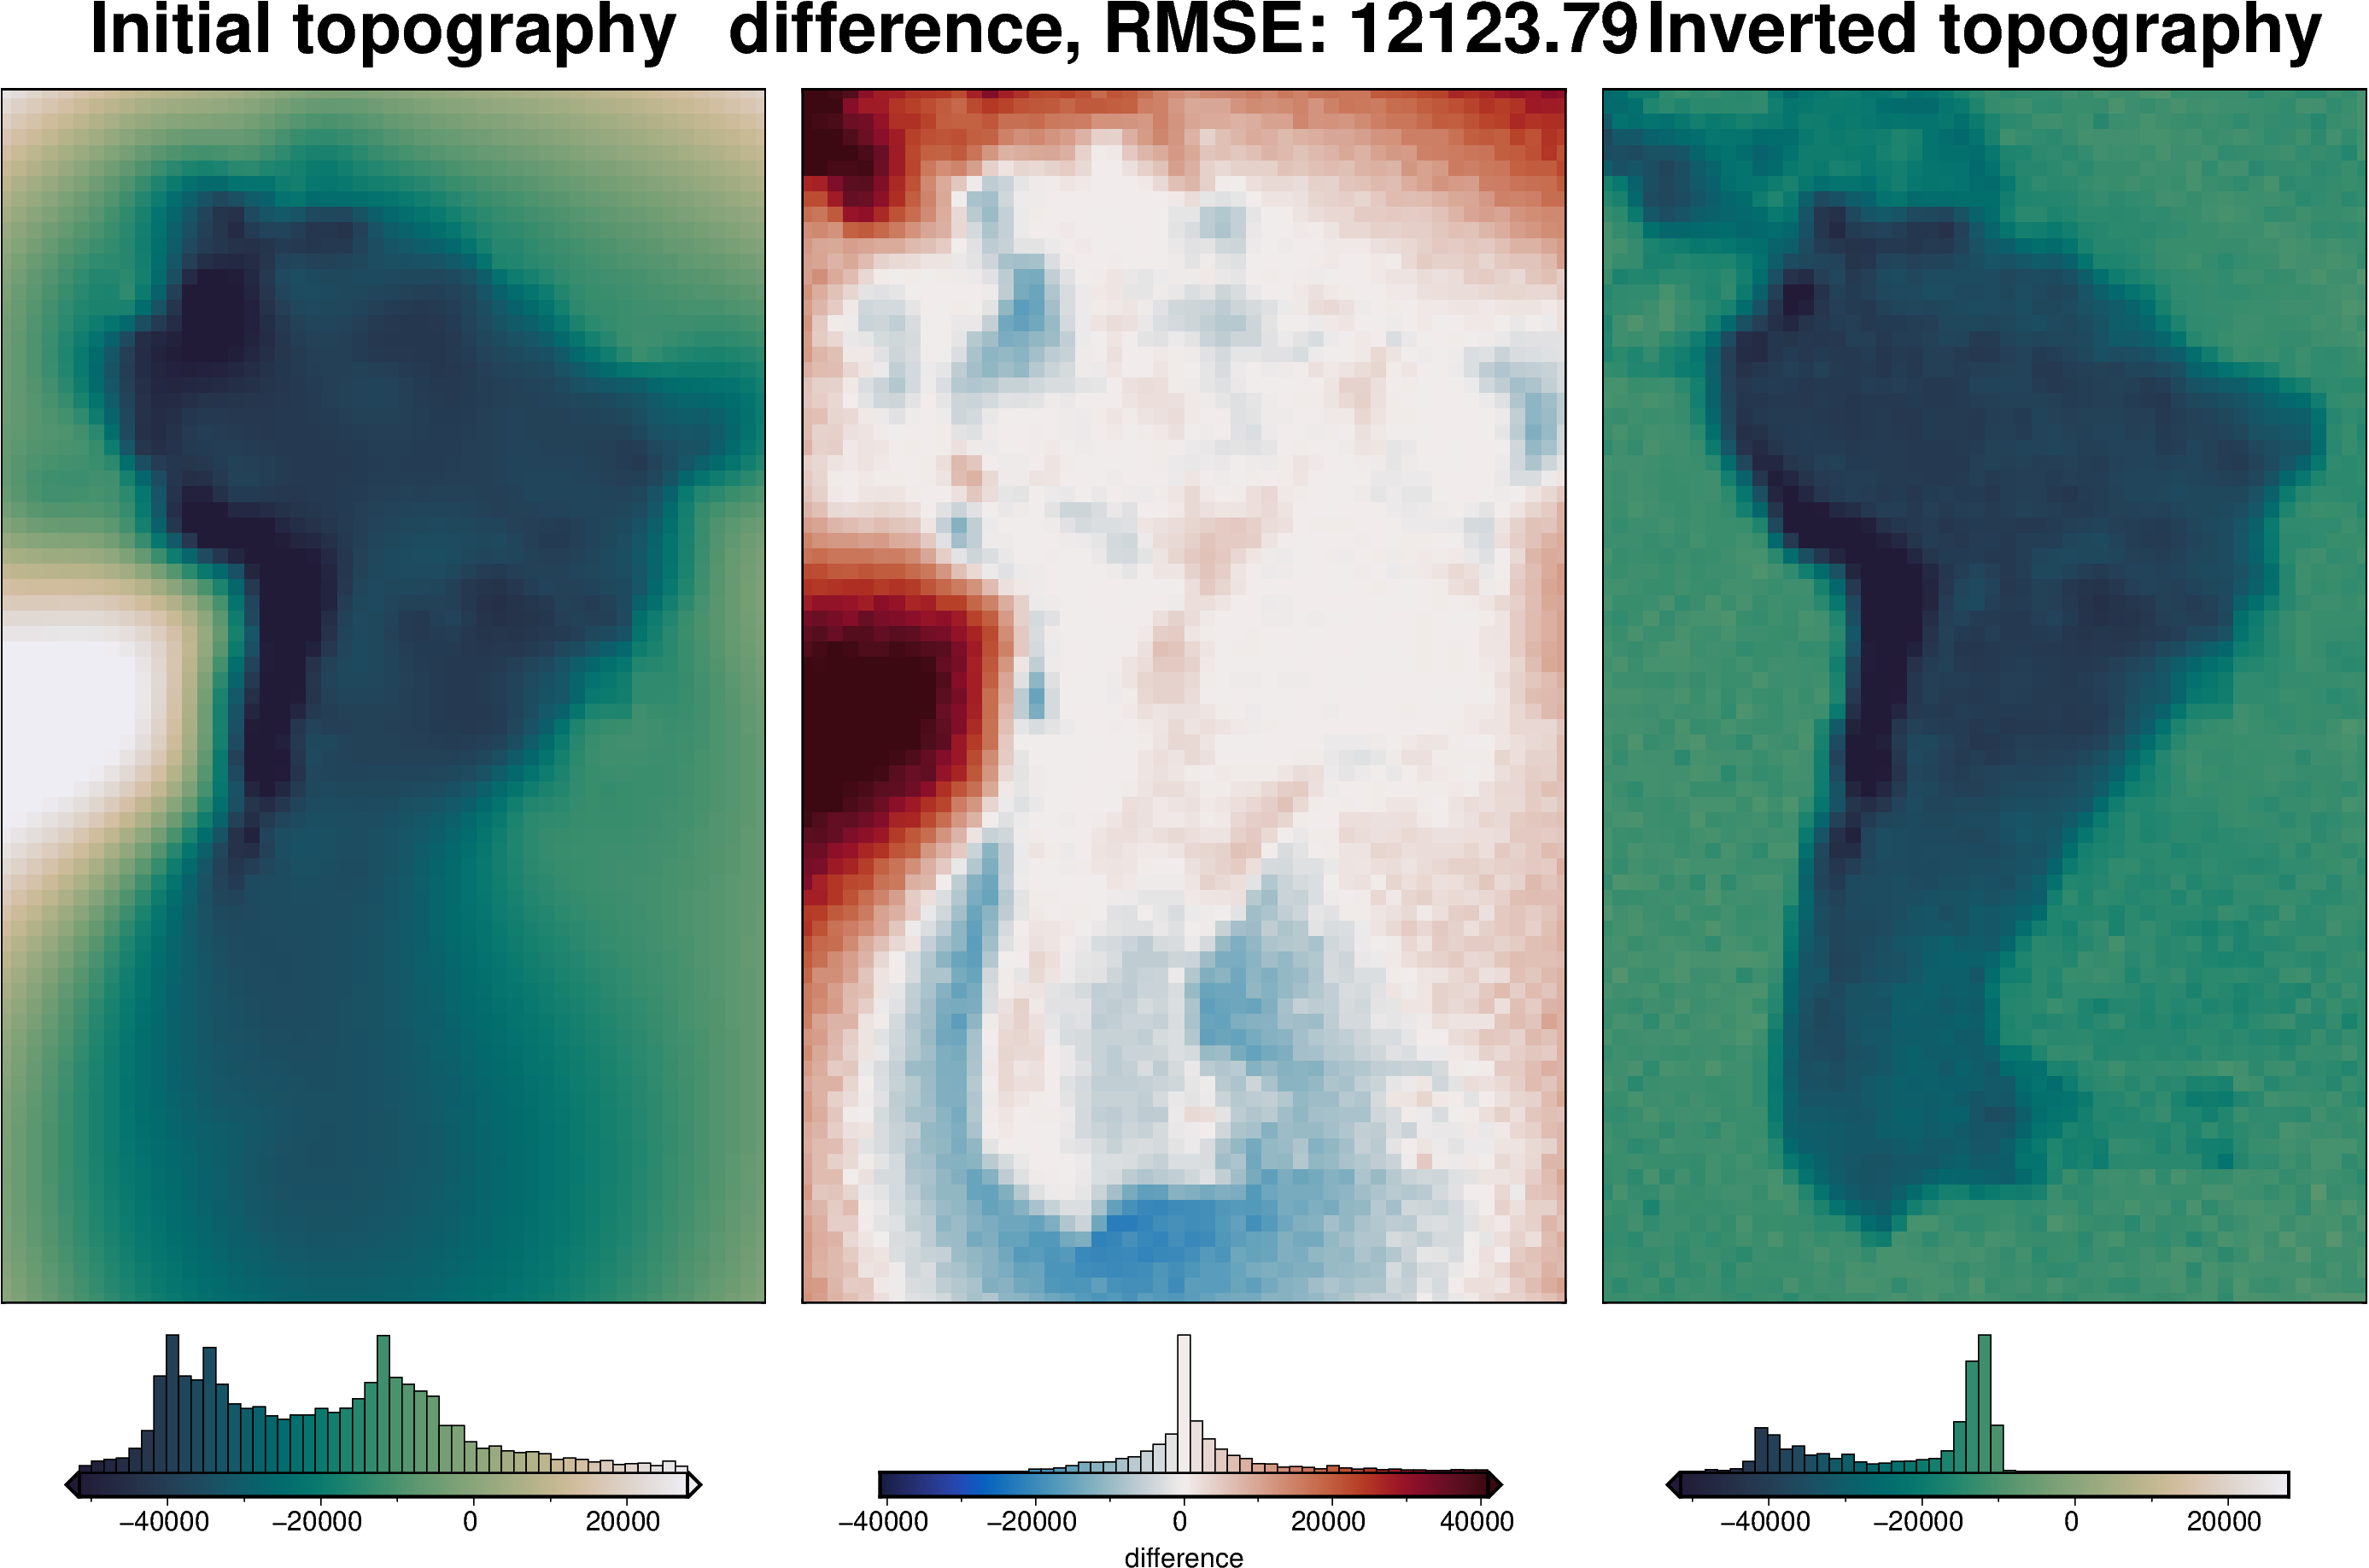

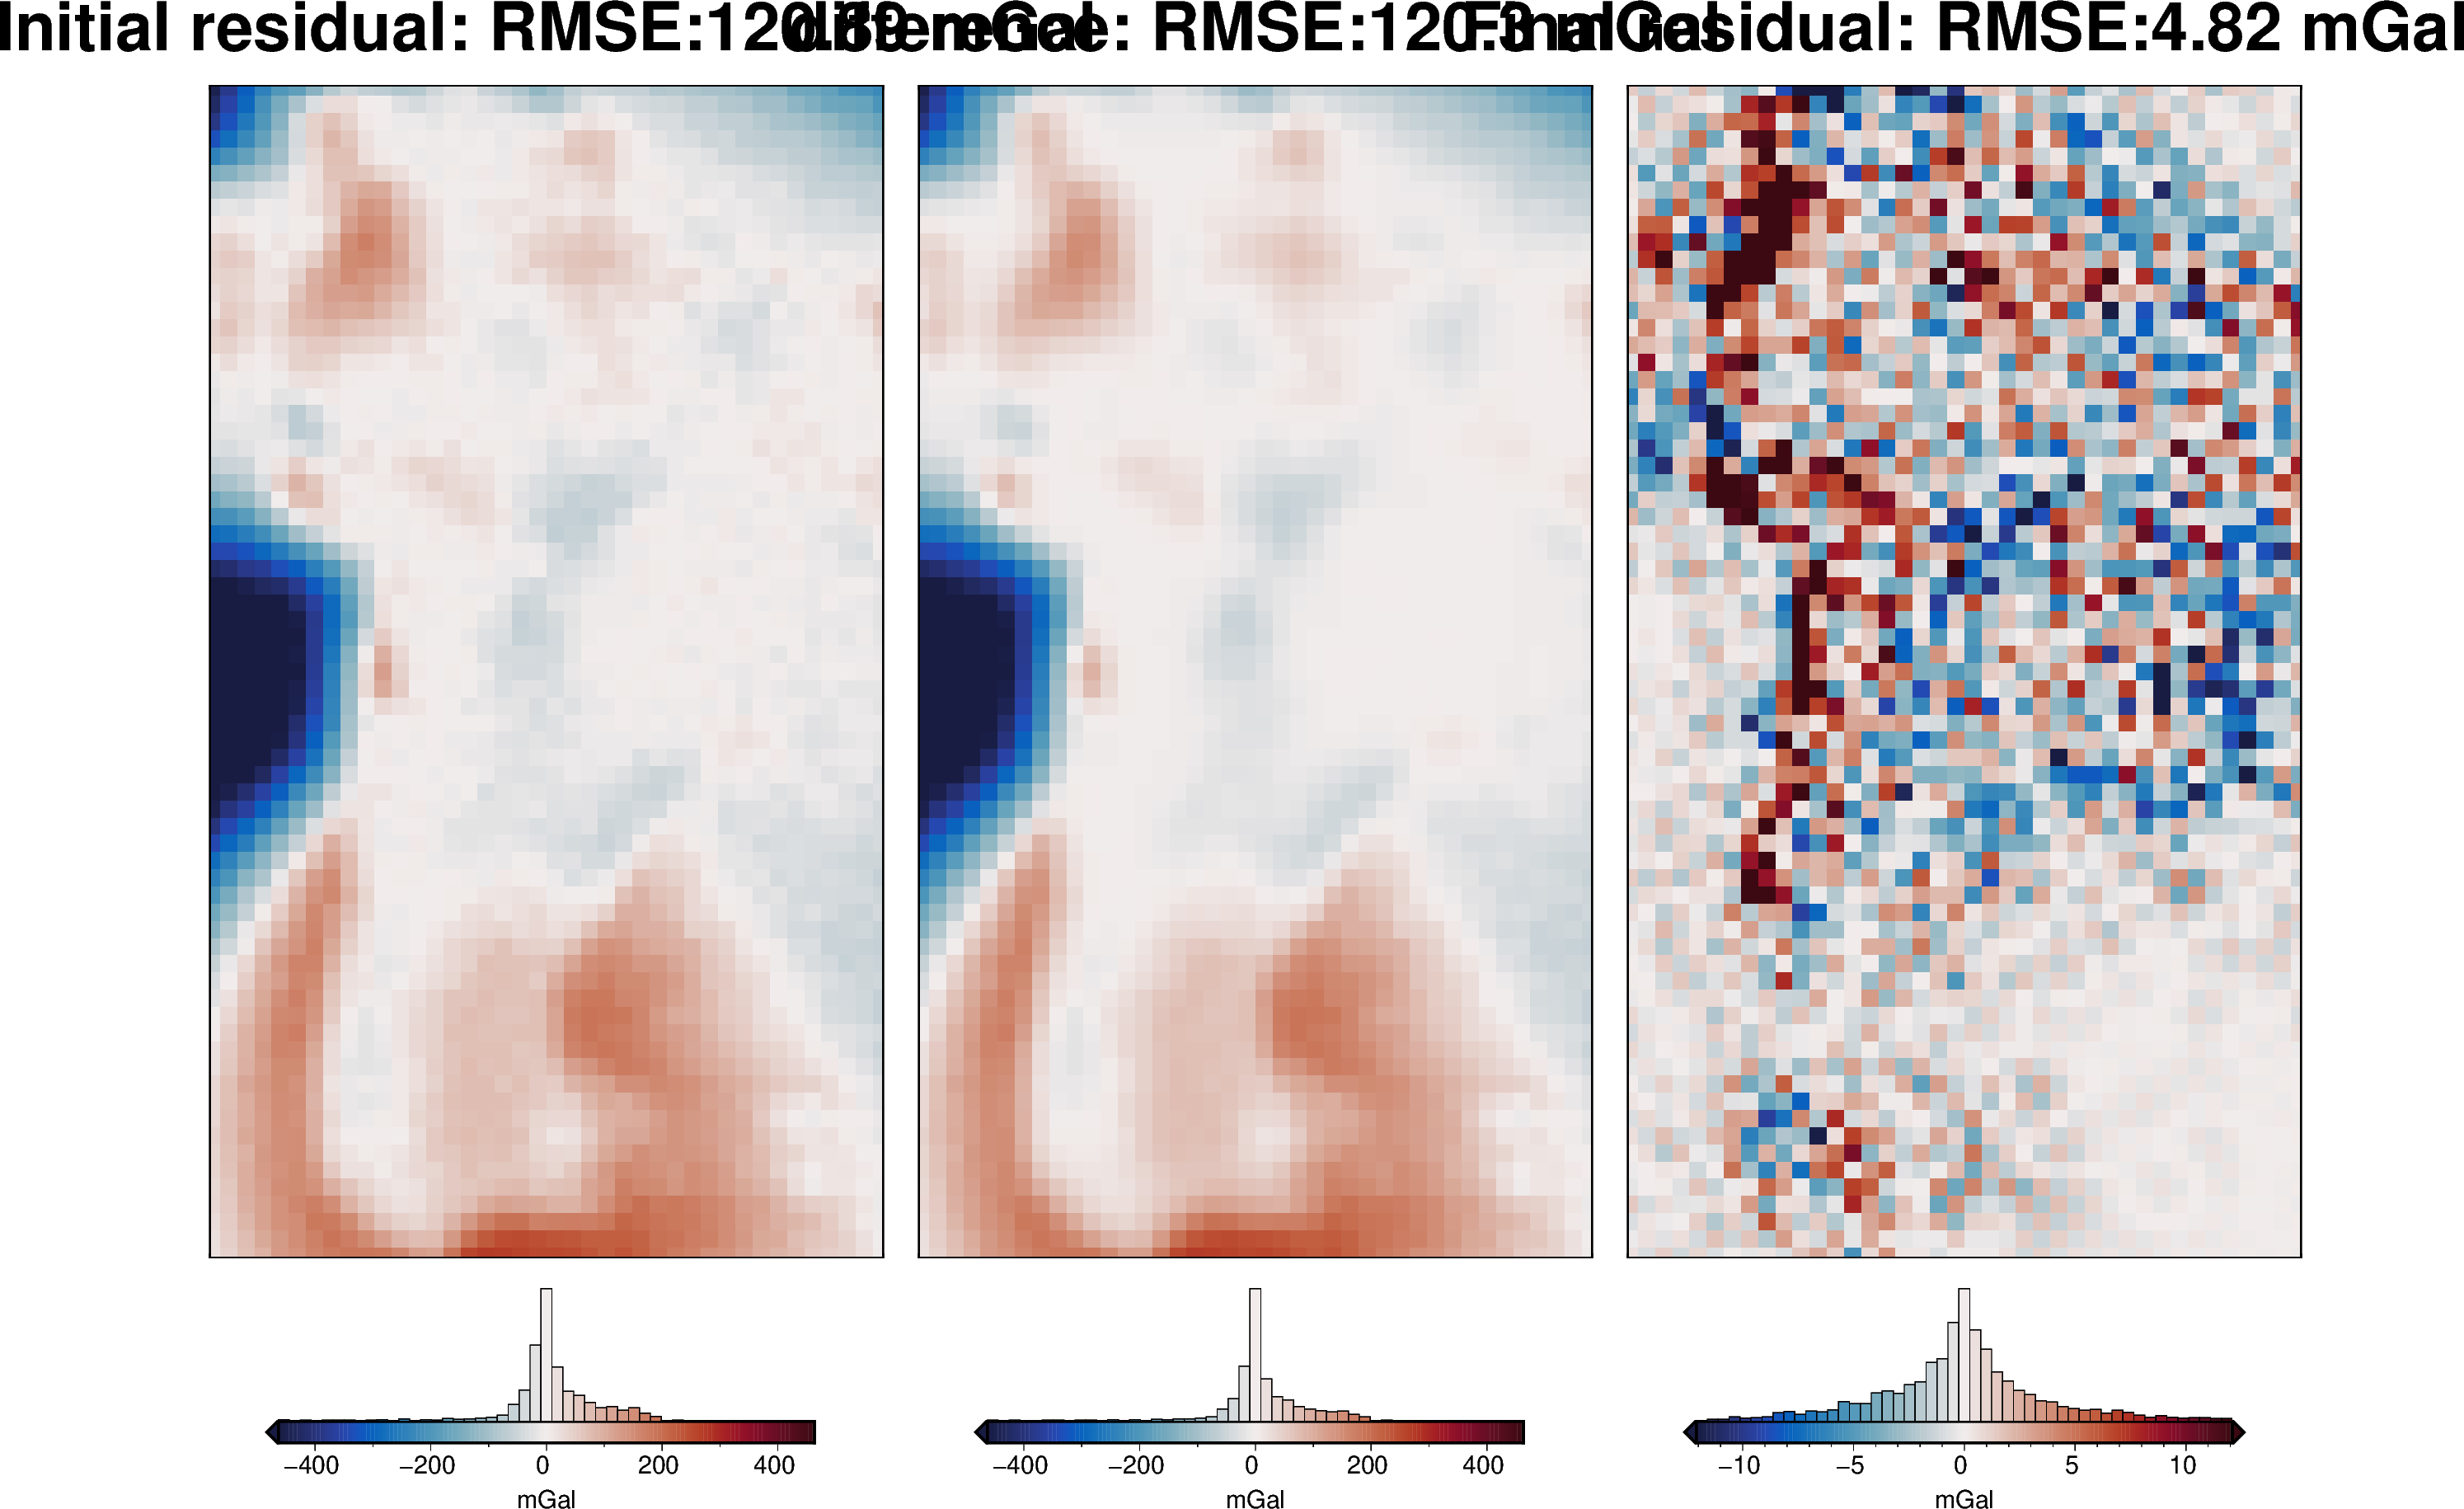

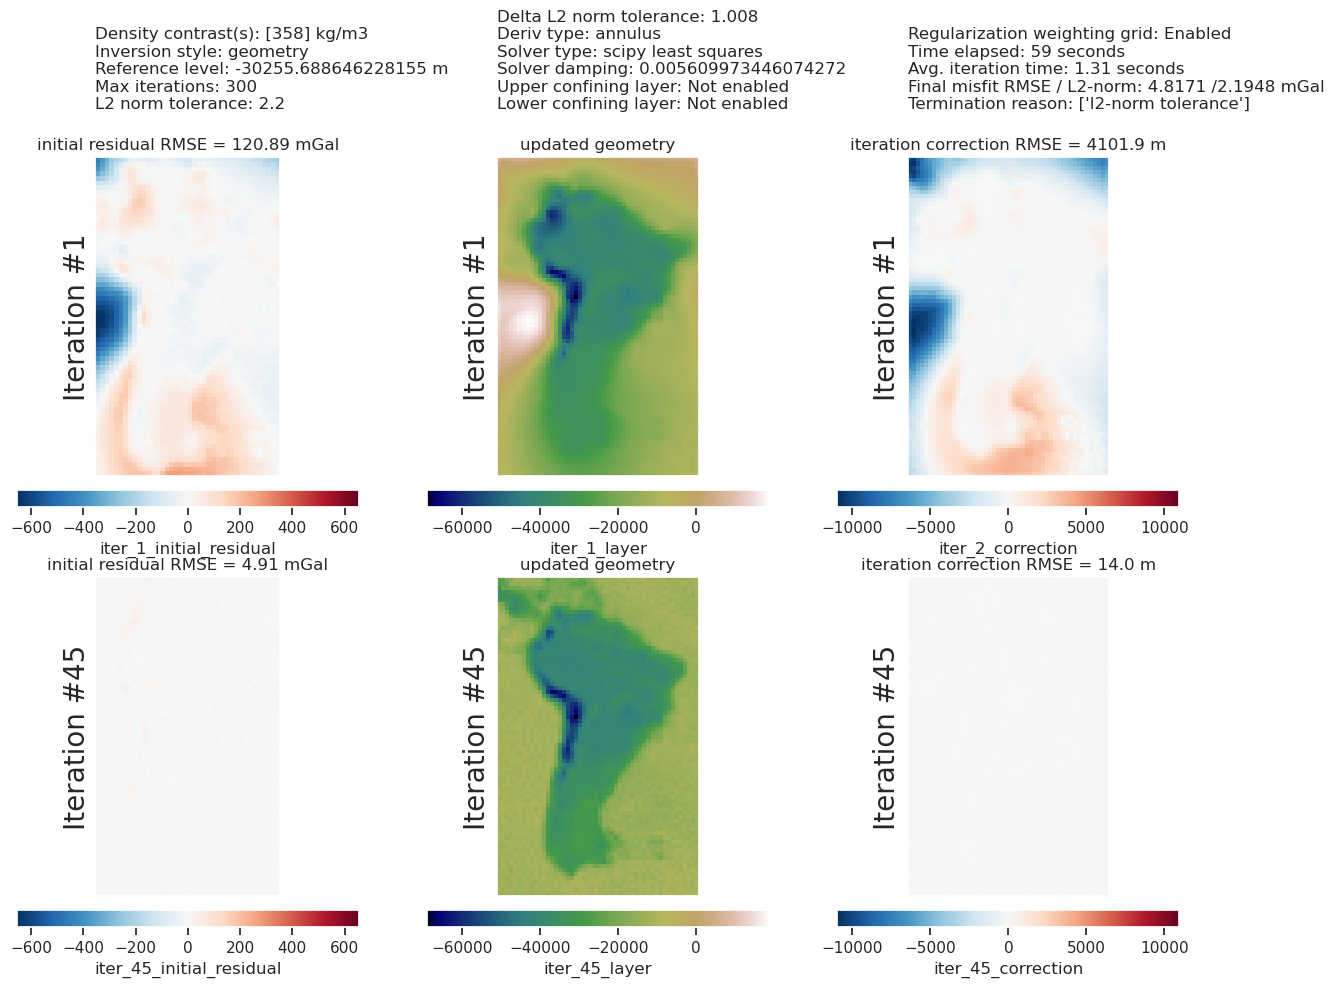

In [40]:
weighted_results.plot_inversion_results(iters_to_plot=2)

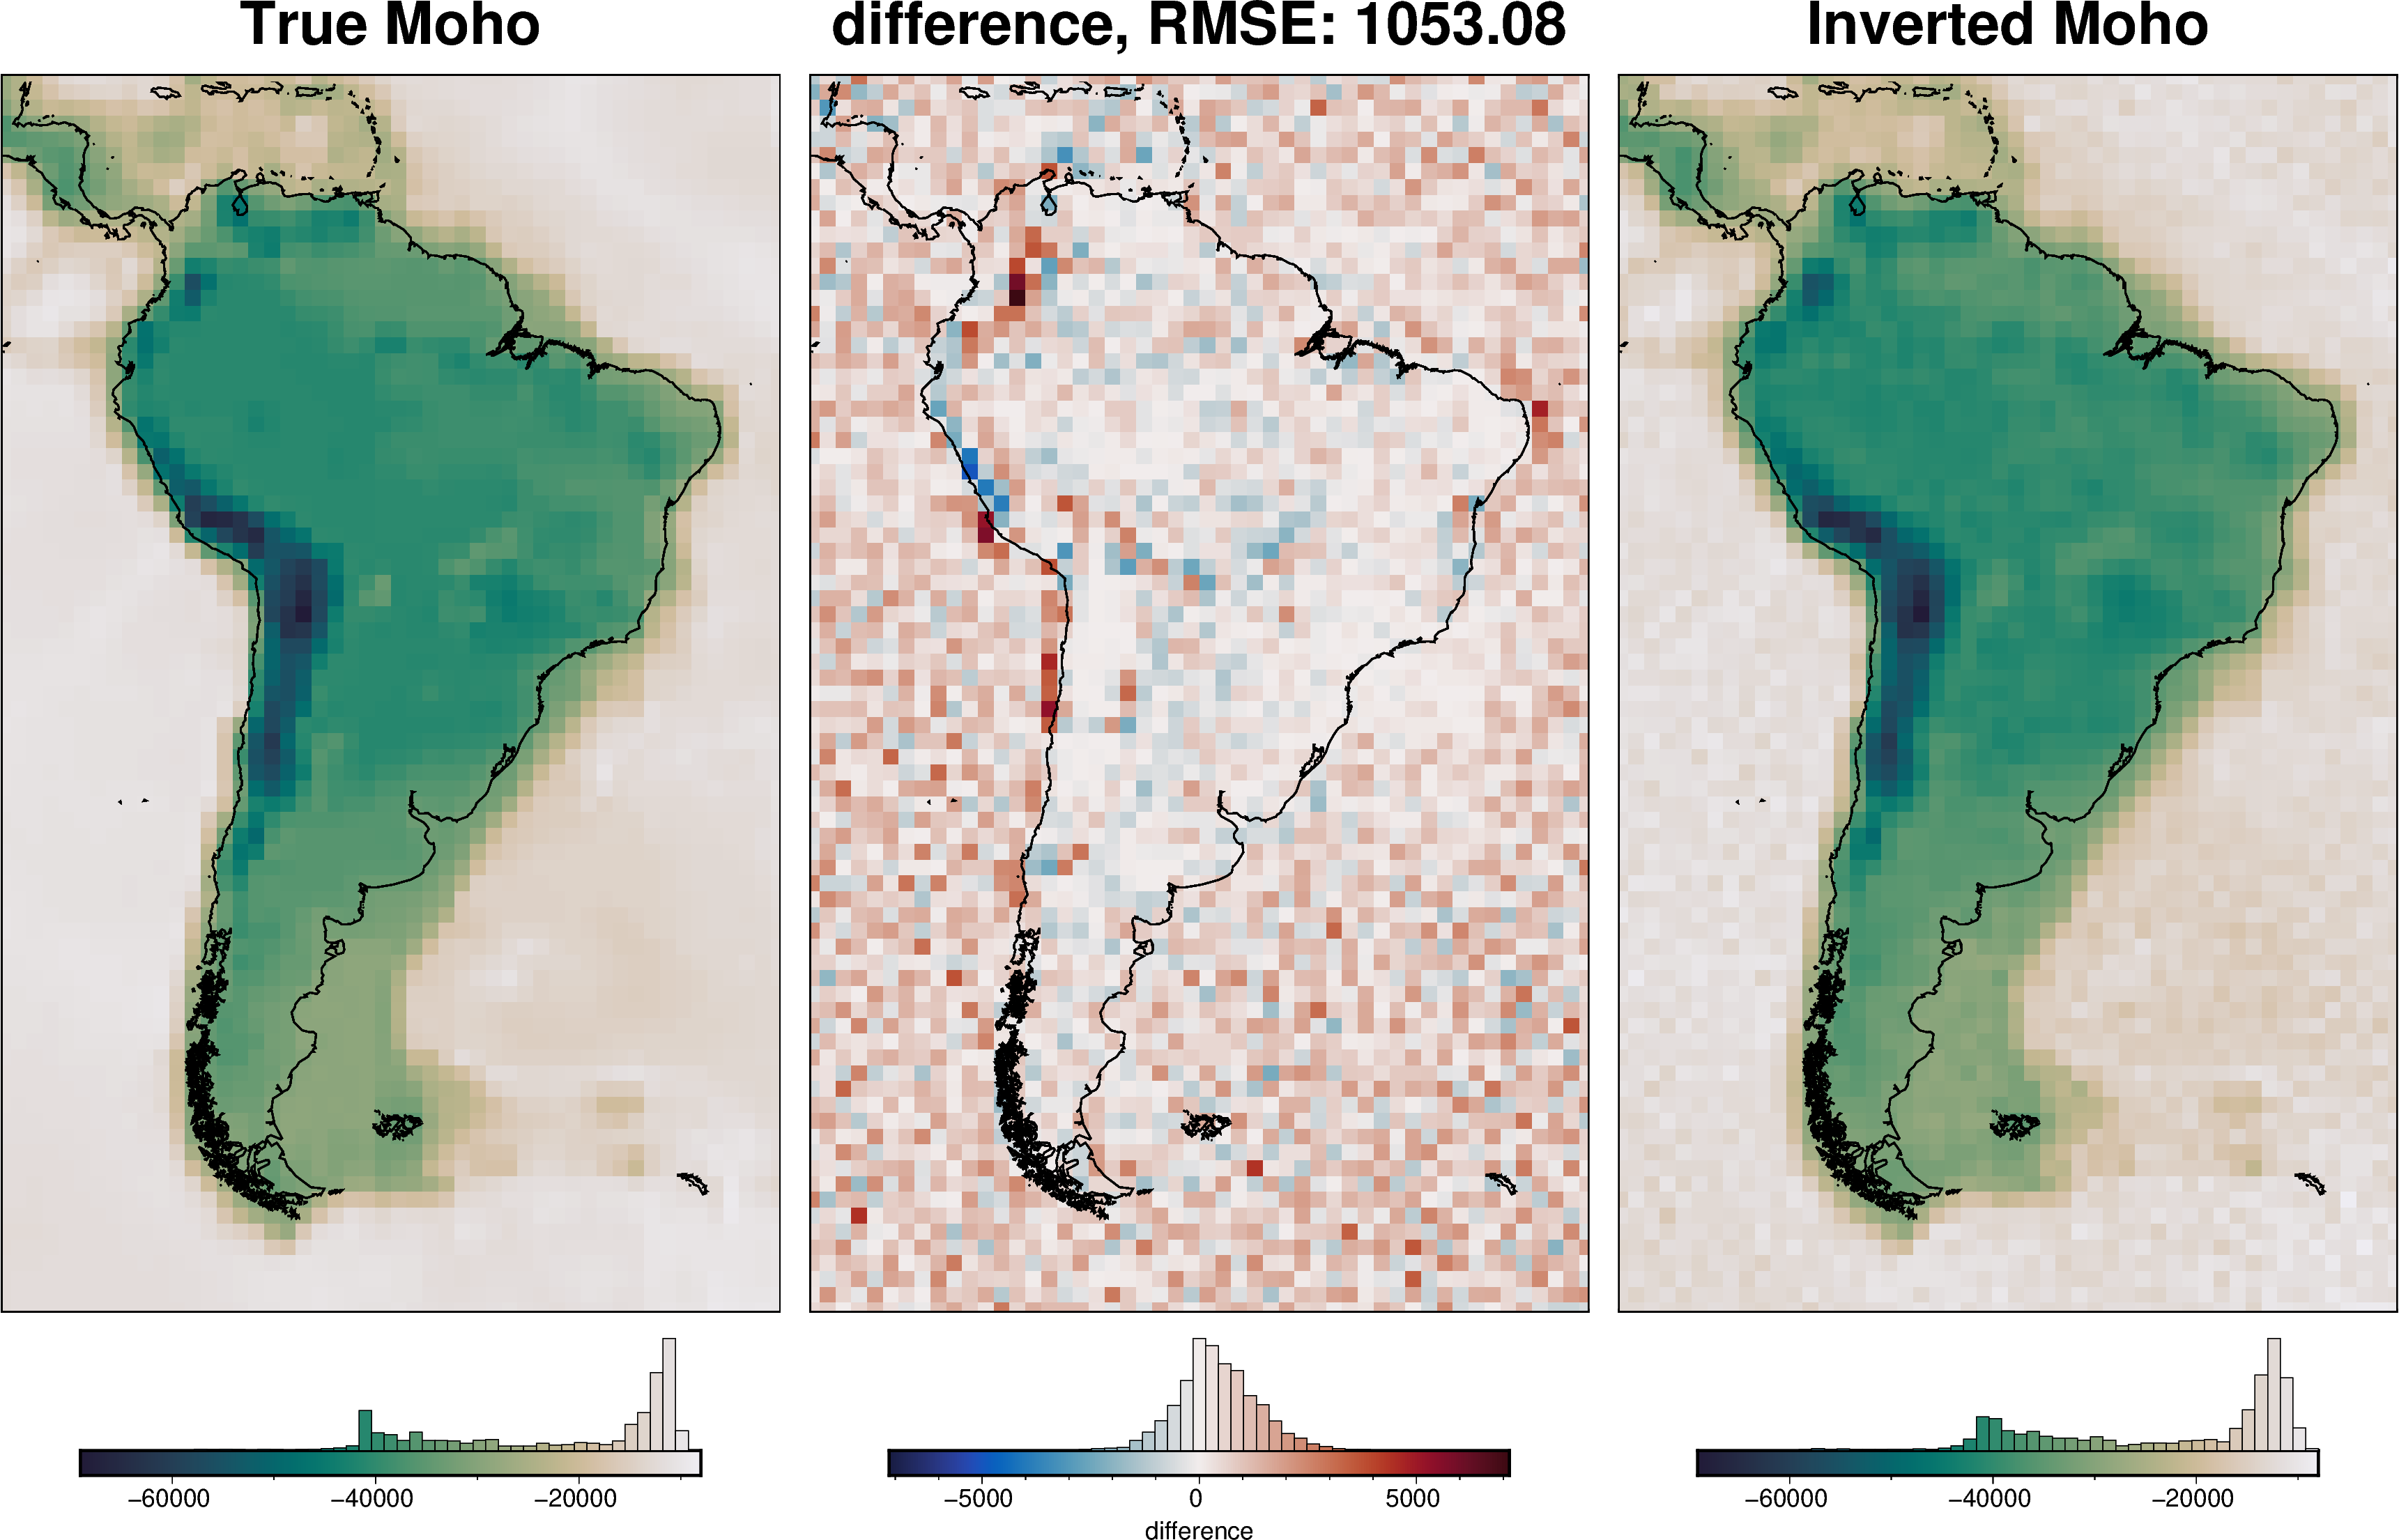

In [41]:
_ = ptk.grid_compare(
    true_moho,
    weighted_results.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    coast=True,
)